In [1]:
# This notebook allows replicating the experiments described in "Experiments" section of the thesis

In [2]:
import os
os.chdir("..")

In [2]:
import torch
import nltk
import re
import pandas as pd
import plotly.express as px
from experiments.enhancing_with_ner import test_enhancing_text_used_to_train_re
from experiments.hyperparameters import optuna_hp_space, optuna_hp_space_scientific
from experiments.model_size import test_ner_quality_depending_on_dataset_size, test_re_quality_depending_on_dataset_size
from named_entity.named_entity_model import NamedEntityModel
from relations.relations_model import RelationsModel
from utils.evaluation import evaluate_with_division_between_column
from utils.optuna_reader import read_optuna_logs
from utils.prediction import train_re_on_ner, predict_joint_models
from utils.preprocessing import filter_out_wrong_data
from utils.overlap import create_full_matrix
from utils.enhancement import enhance_with_nothing, enhance_with_entity, enhance_with_brackets, \
    enhance_with_entity_differentiated, enhance_with_special_characters, enhance_entities_only
from experiments.hyperparameters import test_hyperparameters_impact
from experiments.sample_languages import run_experiments_linguistic, perform_four_variations_linguistic, train_and_evaluate_on_language_subsets
from utils.overlap import remove_overlapping_entities
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_colwidth', 500)

In [4]:
import wandb

wandb.init(mode="disabled")

# Hyperparameter optimization

In [10]:
NER_BROAD_FILE_PATH='results/hyperparameter_optimization_ner_broad.txt'
RE_BROAD_FILE_PATH='results/hyperparameter_optimization_re_broad.txt'
NER_SCIENTIFIC_FILE_PATH='results/hyperparameter_optimization_ner_scientific.txt'
RE_SCIENTIFIC_FILE_PATH='results/hyperparameter_optimization_re_scientific.txt'

In [11]:
torch.cuda.empty_cache()
train_df = pd.read_csv("merged_train.tsv", sep="\t")
test_df = pd.read_csv("merged_test.tsv", sep="\t")
train_df=train_df.sample(frac=0.02,random_state=42)
train_df = filter_out_wrong_data(train_df)
test_df = filter_out_wrong_data(test_df)
ner_model=NamedEntityModel()
re_model=RelationsModel()

FileNotFoundError: [Errno 2] No such file or directory: 'merged_train.tsv'

## Broad search

In [ ]:
%%capture captured
ner_model.perform_hyperparameter_search(space=optuna_hp_space,train_df=train_df, study_name="ner_hyperparameter_search_broad")
with open(NER_BROAD_FILE_PATH, 'w') as f:
    f.write(captured.stdout)

In [ ]:
%%capture captured
re_model.perform_hyperparameter_search(space=optuna_hp_space,train_df=train_df, study_name="re_hyperparameter_search_broad")
with open(RE_BROAD_FILE_PATH, 'w') as f:
    f.write(captured.stdout)

## Scientific-based search

In [ ]:
%%capture captured
ner_model.perform_hyperparameter_search(space=optuna_hp_space_scientific,train_df=train_df, study_name="ner_hyperparameter_search_scientific")
with open(NER_SCIENTIFIC_FILE_PATH, 'w') as f:
    f.write(captured.stdout)

In [ ]:
%%capture captured
re_model.perform_hyperparameter_search(space=optuna_hp_space_scientific,train_df=train_df, study_name="re_hyperparameter_search_scientific")
with open(RE_SCIENTIFIC_FILE_PATH, 'w') as f:
    f.write(captured.stdout)

## Analysis

In [ ]:
def plot_histogram(df, column, yaxis_range=None):
    fig = px.histogram(df, x=column, y="metric", title=f"{column} impact on metric", histfunc='avg')
    # Check if a y-axis range is provided, and if so, set it
    if yaxis_range:
        fig.update_layout(yaxis=dict(range=yaxis_range))
    fig.show()

def plot_scatter(df, column, yaxis_range=None):
    fig = px.scatter(df, x=column, y="metric", title=f"{column} impact on metric")
    # Check if a y-axis range is provided, and if so, set it
    if yaxis_range:
        fig.update_layout(yaxis=dict(range=yaxis_range))
    fig.show()


def analyze_optuna_results(
    file_path,
    all_histograms=False,
    exclude_columns=["metric", "trial_number", "trial_runtime"],
    calculate_correlation=True,
    yaxis_range=None
):
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    print(f"Analyzing: {file_name}")
    df = read_optuna_logs(file_path)
    for column in df.columns:
        if column not in exclude_columns:
            if all_histograms or df[column].dtype == 'int64':
                plot_histogram(df, column, yaxis_range)
            else:
                plot_scatter(df, column, yaxis_range)
    plot_scatter(df, "trial_number", yaxis_range)
    if calculate_correlation:
        correlation_data = []
        for column in df.columns:
            if column not in exclude_columns:
                corr = df[column].corr(df['metric'], method='spearman')
                corr = round(corr, 2)
                correlation_data.append({'Parameter': column, 'Spearman Correlation': corr})
        correlation_df = pd.DataFrame(correlation_data)
        print("Spearman Correlations with Metric:")
        display(correlation_df.sort_values(by='Spearman Correlation', ascending=False))
    display(df.sort_values(by="metric", ascending=False))

def compare_two_studies(exploratory_file_path, literature_based_file_path, yaxis_range=None):
    df1 = read_optuna_logs(exploratory_file_path)
    df2 = read_optuna_logs(literature_based_file_path)
    df1['study'] = "exploratory"
    df2['study'] = "literature-based"
    combined_df = pd.concat([df1, df2], ignore_index=True)
    fig = px.scatter(combined_df, x='trial_number', y='metric', color='study', title="Trial number vs F1")
    fig.update_layout(showlegend=False)
    if yaxis_range:
        fig.update_layout(yaxis=dict(range=yaxis_range))
    fig.update_xaxes(tickvals=list(range(0,50)))
    fig.show()

In [ ]:
analyze_optuna_results(file_path=NER_BROAD_FILE_PATH, yaxis_range=[0.75,0.85])

In [ ]:
analyze_optuna_results(file_path=RE_BROAD_FILE_PATH, yaxis_range=[0.9,1])

In [ ]:
analyze_optuna_results(file_path=NER_SCIENTIFIC_FILE_PATH, yaxis_range=[0.75,0.85], all_histograms=True)

In [ ]:
analyze_optuna_results(file_path=RE_SCIENTIFIC_FILE_PATH, yaxis_range=[0.9,1], all_histograms=True)

In [ ]:
compare_two_studies(NER_BROAD_FILE_PATH, NER_SCIENTIFIC_FILE_PATH, [0.75,0.85])

In [ ]:
compare_two_studies(RE_BROAD_FILE_PATH, RE_SCIENTIFIC_FILE_PATH, [0.9,1])

## Freezing hyperparameters

In [5]:
torch.cuda.empty_cache()
train_df = pd.read_csv("data/merged_train.tsv", sep="\t")
test_df = pd.read_csv("data/merged_test.tsv", sep="\t")
train_df=train_df.sample(frac=0.1,random_state=42)
train_df = filter_out_wrong_data(train_df)
test_df = filter_out_wrong_data(test_df)
ner_model=NamedEntityModel('models/freezing_hyperparameters')
re_model=RelationsModel('models/freezing_re_hyperparameters')

C:\Users\micha\AppData\Local\Temp\ipykernel_15940\2232928715.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("data/merged_train.tsv", sep="\t")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["id"] = df["id"].astype("int")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [6]:
ner_results_freezing=test_hyperparameters_impact(ner_model,train_df,test_df)

Hyperparameter learning_rate, value 2e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.121200,0.117468,0.886246,0.799925,0.840876,0.956940,0.936013,0.691614
2,0.099300,0.112131,0.870281,0.841345,0.855569,0.960186,0.942431,0.732076
3,0.074200,0.114701,0.876910,0.837882,0.856952,0.961410,0.944268,0.730072


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:65: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter learning_rate, value 3e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.125700,0.125577,0.868703,0.800479,0.833197,0.955937,0.933222,0.681011
2,0.096700,0.115587,0.853669,0.847693,0.850670,0.958417,0.940689,0.726102
3,0.070000,0.118743,0.869463,0.840360,0.854664,0.958885,0.940999,0.730276


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter learning_rate, value 4e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.127000,0.130552,0.879521,0.777847,0.825565,0.954694,0.933628,0.653953
2,0.096900,0.118956,0.855394,0.848357,0.851861,0.958270,0.940769,0.728001
3,0.071300,0.124400,0.870388,0.840764,0.855320,0.959587,0.942425,0.730286


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter learning_rate, value 5e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049400,0.154771,0.851849,0.855328,0.853585,0.957400,0.940533,0.733684


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 1


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.115100,0.111277,0.874977,0.826013,0.849790,0.958873,0.937894,0.718607


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 2


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.124200,0.121977,0.870090,0.799007,0.833035,0.955823,0.935547,0.676893
2,0.083200,0.110973,0.874432,0.839003,0.856352,0.960553,0.941311,0.732606


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 3


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128800,0.120783,0.875008,0.796943,0.834153,0.956352,0.934265,0.680055
2,0.091300,0.114038,0.857420,0.848299,0.852835,0.958913,0.940786,0.730363
3,0.060300,0.123339,0.871147,0.845571,0.858168,0.960373,0.943388,0.736003


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 4


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128700,0.127434,0.877368,0.792685,0.832880,0.955862,0.931302,0.679669
2,0.094600,0.115567,0.851493,0.849699,0.850595,0.958694,0.939335,0.727883
3,0.065300,0.121639,0.873894,0.841010,0.857137,0.959764,0.942568,0.732610


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 5


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.129400,0.126725,0.865855,0.809053,0.836491,0.956003,0.932736,0.692303
2,0.096300,0.116552,0.863155,0.836045,0.849383,0.958461,0.938207,0.722524
3,0.071000,0.124760,0.880133,0.830690,0.854697,0.959511,0.940256,0.728103


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 6


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049300,0.154952,0.851818,0.855704,0.853757,0.957371,0.940880,0.733690


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.0


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049300,0.154952,0.851818,0.855704,0.853757,0.957371,0.940880,0.733690


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.136700,0.134208,0.867551,0.797188,0.830882,0.954991,0.930897,0.678318
2,0.107100,0.119399,0.858565,0.832826,0.845500,0.957097,0.934602,0.717353
3,0.079400,0.124417,0.884004,0.825450,0.853724,0.959154,0.937693,0.727677


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.1


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.139300,0.138722,0.882613,0.770644,0.822837,0.953375,0.931366,0.647881
2,0.107600,0.119811,0.859063,0.839335,0.849085,0.957789,0.937103,0.723083
3,0.080900,0.120243,0.884209,0.820485,0.851156,0.959077,0.939817,0.717757


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.15


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.144600,0.141646,0.864968,0.785901,0.823541,0.952975,0.929893,0.658907
2,0.112800,0.120005,0.845942,0.838469,0.842189,0.957048,0.935202,0.712230
3,0.084300,0.117006,0.884287,0.821553,0.851766,0.959111,0.940313,0.718611
4,0.059500,0.130907,0.862014,0.850493,0.856215,0.959384,0.943085,0.734056


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.2


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.140600,0.146882,0.858673,0.794720,0.825460,0.952564,0.928163,0.670725
2,0.118700,0.119358,0.866723,0.817107,0.841184,0.956491,0.933825,0.702946
3,0.086700,0.116724,0.883320,0.824454,0.852872,0.959258,0.940117,0.722723
4,0.062200,0.133268,0.846757,0.858258,0.852469,0.957521,0.940261,0.732275


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.0


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049300,0.154952,0.851818,0.855704,0.853757,0.957371,0.940880,0.733690


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.001


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128600,0.128517,0.875370,0.790058,0.830529,0.955365,0.932090,0.670945
2,0.100000,0.118291,0.866495,0.835640,0.850788,0.958848,0.938761,0.724711
3,0.074700,0.127845,0.880841,0.825522,0.852285,0.959243,0.939313,0.721533


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.01


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.130741,0.866695,0.777587,0.819726,0.953781,0.929011,0.649158
2,0.098900,0.121452,0.844386,0.847043,0.845713,0.956437,0.938213,0.718788
3,0.075500,0.121136,0.870208,0.838845,0.854239,0.959379,0.941615,0.727587
4,0.051300,0.155734,0.855439,0.852846,0.854140,0.957514,0.940664,0.734015


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.1


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130200,0.126985,0.866433,0.802139,0.833047,0.955551,0.932571,0.681729
2,0.099000,0.115212,0.849357,0.844012,0.846676,0.958026,0.936356,0.721362
3,0.073000,0.117575,0.875705,0.833374,0.854016,0.959422,0.940055,0.728299


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.2


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.131800,0.129168,0.878619,0.792901,0.833562,0.955544,0.932124,0.680068
2,0.100100,0.116929,0.849166,0.846249,0.847705,0.958156,0.939559,0.720116
3,0.072800,0.120167,0.872459,0.835814,0.853743,0.958600,0.939898,0.728709


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.3


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128600,0.124614,0.883087,0.789235,0.833528,0.955589,0.931390,0.679882
2,0.099800,0.118506,0.859217,0.833879,0.846358,0.957988,0.938145,0.714803
3,0.075500,0.122208,0.884931,0.824757,0.853785,0.959716,0.940256,0.724150


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

[{'Hyperparameter': 'learning_rate', 'Value': 2e-05, 'Evaluation Result': {'eval_loss': 0.11322426050901413, 'eval_overall_precision': 0.8692156434345641, 'eval_overall_recall': 0.8440138604059119, 'eval_overall_f1': 0.8564293915040183, 'eval_overall_accuracy': 0.9602712166083543, 'eval_Entity1_f1': 0.944621291278886, 'eval_Entity2_f1': 0.7292039120832895, 'eval_runtime': 39.8217, 'eval_samples_per_second': 553.567, 'eval_steps_per_second': 69.208}}, {'Hyperparameter': 'learning_rate', 'Value': 3e-05, 'Evaluation Result': {'eval_loss': 0.11369756609201431, 'eval_overall_precision': 0.8573470758938144, 'eval_overall_recall': 0.8482285552648328, 'eval_overall_f1': 0.8527634404015413, 'eval_overall_accuracy': 0.9591533570381062, 'eval_Entity1_f1': 0.9432900538354729, 'eval_Entity2_f1': 0.7258350980258215, 'eval_runtime': 39.9447, 'eval_samples_per_second': 551.864, 'eval_steps_per_second': 68.995}}, {'Hyperparameter': 'learning_rate', 'Value': 4e-05, 'Evaluation Result': {'eval_loss': 0.1

In [7]:
ner_results_freezing

,Hyperparameter,Value,Evaluation Result
0,learning_rate,0.00002,"{'eval_loss': 0.11322426050901413, 'eval_overall_precision': 0.8692156434345641, 'eval_overall_recall': 0.8440138604059119, 'eval_overall_f1': 0.8564293915040183, 'eval_overall_accuracy': 0.9602712166083543, 'eval_Entity1_f1': 0.944621291278886, 'eval_Entity2_f1': 0.7292039120832895, 'eval_runtime': 39.8217, 'eval_samples_per_second': 553.567, 'eval_steps_per_second': 69.208}"
1,learning_rate,0.00003,"{'eval_loss': 0.11369756609201431, 'eval_overall_precision': 0.8573470758938144, 'eval_overall_recall': 0.8482285552648328, 'eval_overall_f1': 0.8527634404015413, 'eval_overall_accuracy': 0.9591533570381062, 'eval_Entity1_f1': 0.9432900538354729, 'eval_Entity2_f1': 0.7258350980258215, 'eval_runtime': 39.9447, 'eval_samples_per_second': 551.864, 'eval_steps_per_second': 68.995}"
2,learning_rate,0.00004,"{'eval_loss': 0.11661513894796371, 'eval_overall_precision': 0.8577121391741533, 'eval_overall_recall': 0.8493175871579096, 'eval_overall_f1': 0.8534942224875283, 'eval_overall_accuracy': 0.9595277857291117, 'eval_Entity1_f1': 0.9415672104821343, 'eval_Entity2_f1': 0.7297893064028298, 'eval_runtime': 39.8514, 'eval_samples_per_second': 553.155, 'eval_steps_per_second': 69.157}"
3,learning_rate,0.00005,"{'eval_loss': 0.11524178087711334, 'eval_overall_precision': 0.8815807240484299, 'eval_overall_recall': 0.8310586238596988, 'eval_overall_f1': 0.8555744841945864, 'eval_overall_accuracy': 0.9600568697490107, 'eval_Entity1_f1': 0.9412965798876978, 'eval_Entity2_f1': 0.7275236020334062, 'eval_runtime': 39.6649, 'eval_samples_per_second': 555.756, 'eval_steps_per_second': 69.482}"
4,num_train_epochs,1.00000,"{'eval_loss': 0.10941081494092941, 'eval_overall_precision': 0.8728483927214199, 'eval_overall_recall': 0.8283572590340146, 'eval_overall_f1': 0.8500210440764554, 'eval_overall_accuracy': 0.9593310750037647, 'eval_Entity1_f1': 0.9400612583382768, 'eval_Entity2_f1': 0.7152975273978806, 'eval_runtime': 39.9905, 'eval_samples_per_second': 551.23, 'eval_steps_per_second': 68.916}"
5,num_train_epochs,2.00000,"{'eval_loss': 0.11067797988653183, 'eval_overall_precision': 0.8775320654577621, 'eval_overall_recall': 0.8418499398910968, 'eval_overall_f1': 0.8593207492691378, 'eval_overall_accuracy': 0.9608382861476307, 'eval_Entity1_f1': 0.9445953813312634, 'eval_Entity2_f1': 0.733966872893897, 'eval_runtime': 39.8909, 'eval_samples_per_second': 552.607, 'eval_steps_per_second': 69.088}"
6,num_train_epochs,3.00000,"{'eval_loss': 0.11248845607042313, 'eval_overall_precision': 0.8610478033397836, 'eval_overall_recall': 0.8496004525846829, 'eval_overall_f1': 0.8552858261550509, 'eval_overall_accuracy': 0.9597977542418293, 'eval_Entity1_f1': 0.9429259863217075, 'eval_Entity2_f1': 0.7317483189241115, 'eval_runtime': 40.1995, 'eval_samples_per_second': 548.366, 'eval_steps_per_second': 68.558}"
7,num_train_epochs,4.00000,"{'eval_loss': 0.11560973525047302, 'eval_overall_precision': 0.8550222310609827, 'eval_overall_recall': 0.8512976451453221, 'eval_overall_f1': 0.8531558730563705, 'eval_overall_accuracy': 0.9591994823116359, 'eval_Entity1_f1': 0.9420348010068215, 'eval_Entity2_f1': 0.7289808538470686, 'eval_runtime': 40.2229, 'eval_samples_per_second': 548.046, 'eval_steps_per_second': 68.518}"
8,num_train_epochs,5.00000,"{'eval_loss': 0.11407621204853058, 'eval_overall_precision': 0.8664739124720725, 'eval_overall_recall': 0.8392192914221059, 'eval_overall_f1': 0.8526288563504949, 'eval_overall_accuracy': 0.9593839834057545, 'eval_Entity1_f1': 0.9420693513664724, 'eval_Entity2_f1': 0.7235416995804589, 'eval_runtime': 40.272, 'eval_samples_per_second': 547.378, 'eval_steps_per_second': 68.435}"
9,num_train_epochs,6.00000,"{'eval_loss': 0.11524178087711334, 'eval_overall_precision': 0.8815807240484299, 'eval_overall_recall': 0.8310586238596988, 'eval_overall_f1': 0.8555744841945864, 'eval_overall_accuracy': 0.9600568697490107, 'eval_Entity1_f1': 0.9412965798876978, 'eval_Entity2_f1': 0

In [8]:
re_results_freezing=test_hyperparameters_impact(ner_model,train_df,test_df)

Hyperparameter learning_rate, value 2e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.125900,0.123275,0.885809,0.786016,0.832934,0.956070,0.932536,0.674832
2,0.097600,0.112126,0.866657,0.839061,0.852636,0.959419,0.941223,0.725980
3,0.075400,0.116562,0.883931,0.831238,0.856775,0.960141,0.942111,0.730218


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter learning_rate, value 3e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.125700,0.125577,0.868703,0.800479,0.833197,0.955937,0.933222,0.681011
2,0.096700,0.115587,0.853669,0.847693,0.850670,0.958417,0.940689,0.726102
3,0.070000,0.118743,0.869463,0.840360,0.854664,0.958885,0.940999,0.730276


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter learning_rate, value 4e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.127000,0.130552,0.879521,0.777847,0.825565,0.954694,0.933628,0.653953
2,0.096900,0.118956,0.855394,0.848357,0.851861,0.958270,0.940769,0.728001
3,0.071300,0.124400,0.870388,0.840764,0.855320,0.959587,0.942425,0.730286


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter learning_rate, value 5e-05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049300,0.154952,0.851818,0.855704,0.853757,0.957371,0.940880,0.733690


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 1


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.115100,0.111277,0.874977,0.826013,0.849790,0.958873,0.937894,0.718607


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 2


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.124200,0.121977,0.870090,0.799007,0.833035,0.955823,0.935547,0.676893
2,0.083200,0.110973,0.874432,0.839003,0.856352,0.960553,0.941311,0.732606


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 3


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128800,0.120783,0.875008,0.796943,0.834153,0.956352,0.934265,0.680055
2,0.091300,0.114038,0.857420,0.848299,0.852835,0.958913,0.940786,0.730363
3,0.060300,0.123339,0.871147,0.845571,0.858168,0.960373,0.943388,0.736003


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 4


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128700,0.127434,0.877368,0.792685,0.832880,0.955862,0.931302,0.679669
2,0.094600,0.115567,0.851493,0.849699,0.850595,0.958694,0.939335,0.727883
3,0.065300,0.121639,0.873894,0.841010,0.857137,0.959764,0.942568,0.732610


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 5


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.129400,0.126725,0.865855,0.809053,0.836491,0.956003,0.932736,0.692303
2,0.096300,0.116552,0.863155,0.836045,0.849383,0.958461,0.938207,0.722524
3,0.071000,0.124760,0.880133,0.830690,0.854697,0.959511,0.940256,0.728103


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter num_train_epochs, value 6


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049300,0.154952,0.851818,0.855704,0.853757,0.957371,0.940880,0.733690


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.0


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049300,0.154952,0.851818,0.855704,0.853757,0.957371,0.940880,0.733690


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.05


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.136700,0.134208,0.867551,0.797188,0.830882,0.954991,0.930897,0.678318
2,0.107100,0.119399,0.858565,0.832826,0.845500,0.957097,0.934602,0.717353
3,0.079400,0.124417,0.884004,0.825450,0.853724,0.959154,0.937693,0.727677


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.1


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.139300,0.138722,0.882613,0.770644,0.822837,0.953375,0.931366,0.647881
2,0.107600,0.119811,0.859063,0.839335,0.849085,0.957789,0.937103,0.723083
3,0.080900,0.120243,0.884209,0.820485,0.851156,0.959077,0.939817,0.717757


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.15


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.144600,0.141646,0.864968,0.785901,0.823541,0.952975,0.929893,0.658907
2,0.112800,0.120005,0.845942,0.838469,0.842189,0.957048,0.935202,0.712230
3,0.084300,0.117006,0.884287,0.821553,0.851766,0.959111,0.940313,0.718611
4,0.059500,0.130907,0.862014,0.850493,0.856215,0.959384,0.943085,0.734056


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter warmup_ratio, value 0.2


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.140600,0.146882,0.858673,0.794720,0.825460,0.952564,0.928163,0.670725
2,0.118700,0.119358,0.866723,0.817107,0.841184,0.956491,0.933825,0.702946
3,0.086700,0.116724,0.883320,0.824454,0.852872,0.959258,0.940117,0.722723
4,0.062200,0.133268,0.846757,0.858258,0.852469,0.957521,0.940261,0.732275


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.0


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.126000,0.866602,0.803409,0.833810,0.955684,0.931242,0.685986
2,0.100400,0.119550,0.852354,0.847346,0.849843,0.957516,0.939001,0.726110
3,0.074000,0.117500,0.877787,0.829058,0.852727,0.959208,0.940517,0.723210
4,0.049300,0.154952,0.851818,0.855704,0.853757,0.957371,0.940880,0.733690


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.001


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128600,0.128517,0.875370,0.790058,0.830529,0.955365,0.932090,0.670945
2,0.100000,0.118291,0.866495,0.835640,0.850788,0.958848,0.938761,0.724711
3,0.074700,0.127845,0.880841,0.825522,0.852285,0.959243,0.939313,0.721533


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.01


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130100,0.130741,0.866695,0.777587,0.819726,0.953781,0.929011,0.649158
2,0.098900,0.121452,0.844386,0.847043,0.845713,0.956437,0.938213,0.718788
3,0.075500,0.121136,0.870208,0.838845,0.854239,0.959379,0.941615,0.727587
4,0.051300,0.155734,0.855439,0.852846,0.854140,0.957514,0.940664,0.734015


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.1


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.130200,0.126985,0.866433,0.802139,0.833047,0.955551,0.932571,0.681729
2,0.099000,0.115212,0.849357,0.844012,0.846676,0.958026,0.936356,0.721362
3,0.073000,0.117575,0.875705,0.833374,0.854016,0.959422,0.940055,0.728299


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.2


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.131800,0.129168,0.878619,0.792901,0.833562,0.955544,0.932124,0.680068
2,0.100100,0.116929,0.849166,0.846249,0.847705,0.958156,0.939559,0.720116
3,0.072800,0.120167,0.872459,0.835814,0.853743,0.958600,0.939898,0.728709


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Hyperparameter weight_decay, value 0.3


Map:   0%|          | 0/108049 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.128600,0.124614,0.883087,0.789235,0.833528,0.955589,0.931390,0.679882
2,0.099800,0.118506,0.859217,0.833879,0.846358,0.957988,0.938145,0.714803
3,0.075500,0.122208,0.884931,0.824757,0.853785,0.959716,0.940256,0.724150


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

[{'Hyperparameter': 'learning_rate', 'Value': 2e-05, 'Evaluation Result': {'eval_loss': 0.11062288284301758, 'eval_overall_precision': 0.8698278509894546, 'eval_overall_recall': 0.8411144897814865, 'eval_overall_f1': 0.8552302338289857, 'eval_overall_accuracy': 0.9600731492573152, 'eval_Entity1_f1': 0.9438166713293519, 'eval_Entity2_f1': 0.7271512231152067, 'eval_runtime': 40.0565, 'eval_samples_per_second': 550.323, 'eval_steps_per_second': 68.803}}, {'Hyperparameter': 'learning_rate', 'Value': 3e-05, 'Evaluation Result': {'eval_loss': 0.11369756609201431, 'eval_overall_precision': 0.8573470758938144, 'eval_overall_recall': 0.8482285552648328, 'eval_overall_f1': 0.8527634404015413, 'eval_overall_accuracy': 0.9591533570381062, 'eval_Entity1_f1': 0.9432900538354729, 'eval_Entity2_f1': 0.7258350980258215, 'eval_runtime': 39.8111, 'eval_samples_per_second': 553.715, 'eval_steps_per_second': 69.227}}, {'Hyperparameter': 'learning_rate', 'Value': 4e-05, 'Evaluation Result': {'eval_loss': 0.

In [9]:
re_results_freezing

,Hyperparameter,Value,Evaluation Result
0,learning_rate,0.00002,"{'eval_loss': 0.11062288284301758, 'eval_overall_precision': 0.8698278509894546, 'eval_overall_recall': 0.8411144897814865, 'eval_overall_f1': 0.8552302338289857, 'eval_overall_accuracy': 0.9600731492573152, 'eval_Entity1_f1': 0.9438166713293519, 'eval_Entity2_f1': 0.7271512231152067, 'eval_runtime': 40.0565, 'eval_samples_per_second': 550.323, 'eval_steps_per_second': 68.803}"
1,learning_rate,0.00003,"{'eval_loss': 0.11369756609201431, 'eval_overall_precision': 0.8573470758938144, 'eval_overall_recall': 0.8482285552648328, 'eval_overall_f1': 0.8527634404015413, 'eval_overall_accuracy': 0.9591533570381062, 'eval_Entity1_f1': 0.9432900538354729, 'eval_Entity2_f1': 0.7258350980258215, 'eval_runtime': 39.8111, 'eval_samples_per_second': 553.715, 'eval_steps_per_second': 69.227}"
2,learning_rate,0.00004,"{'eval_loss': 0.11661513894796371, 'eval_overall_precision': 0.8577121391741533, 'eval_overall_recall': 0.8493175871579096, 'eval_overall_f1': 0.8534942224875283, 'eval_overall_accuracy': 0.9595277857291117, 'eval_Entity1_f1': 0.9415672104821343, 'eval_Entity2_f1': 0.7297893064028298, 'eval_runtime': 40.4332, 'eval_samples_per_second': 545.196, 'eval_steps_per_second': 68.162}"
3,learning_rate,0.00005,"{'eval_loss': 0.11524178087711334, 'eval_overall_precision': 0.8815807240484299, 'eval_overall_recall': 0.8310586238596988, 'eval_overall_f1': 0.8555744841945864, 'eval_overall_accuracy': 0.9600568697490107, 'eval_Entity1_f1': 0.9412965798876978, 'eval_Entity2_f1': 0.7275236020334062, 'eval_runtime': 40.4381, 'eval_samples_per_second': 545.129, 'eval_steps_per_second': 68.154}"
4,num_train_epochs,1.00000,"{'eval_loss': 0.10941081494092941, 'eval_overall_precision': 0.8728483927214199, 'eval_overall_recall': 0.8283572590340146, 'eval_overall_f1': 0.8500210440764554, 'eval_overall_accuracy': 0.9593310750037647, 'eval_Entity1_f1': 0.9400612583382768, 'eval_Entity2_f1': 0.7152975273978806, 'eval_runtime': 69.495, 'eval_samples_per_second': 317.203, 'eval_steps_per_second': 39.658}"
5,num_train_epochs,2.00000,"{'eval_loss': 0.11067797988653183, 'eval_overall_precision': 0.8775320654577621, 'eval_overall_recall': 0.8418499398910968, 'eval_overall_f1': 0.8593207492691378, 'eval_overall_accuracy': 0.9608382861476307, 'eval_Entity1_f1': 0.9445953813312634, 'eval_Entity2_f1': 0.733966872893897, 'eval_runtime': 66.8921, 'eval_samples_per_second': 329.546, 'eval_steps_per_second': 41.201}"
6,num_train_epochs,3.00000,"{'eval_loss': 0.11248845607042313, 'eval_overall_precision': 0.8610478033397836, 'eval_overall_recall': 0.8496004525846829, 'eval_overall_f1': 0.8552858261550509, 'eval_overall_accuracy': 0.9597977542418293, 'eval_Entity1_f1': 0.9429259863217075, 'eval_Entity2_f1': 0.7317483189241115, 'eval_runtime': 40.7691, 'eval_samples_per_second': 540.704, 'eval_steps_per_second': 67.6}"
7,num_train_epochs,4.00000,"{'eval_loss': 0.11560973525047302, 'eval_overall_precision': 0.8550222310609827, 'eval_overall_recall': 0.8512976451453221, 'eval_overall_f1': 0.8531558730563705, 'eval_overall_accuracy': 0.9591994823116359, 'eval_Entity1_f1': 0.9420348010068215, 'eval_Entity2_f1': 0.7289808538470686, 'eval_runtime': 40.0972, 'eval_samples_per_second': 549.765, 'eval_steps_per_second': 68.733}"
8,num_train_epochs,5.00000,"{'eval_loss': 0.11407621204853058, 'eval_overall_precision': 0.8664739124720725, 'eval_overall_recall': 0.8392192914221059, 'eval_overall_f1': 0.8526288563504949, 'eval_overall_accuracy': 0.9593839834057545, 'eval_Entity1_f1': 0.9420693513664724, 'eval_Entity2_f1': 0.7235416995804589, 'eval_runtime': 39.9143, 'eval_samples_per_second': 552.284, 'eval_steps_per_second': 69.048}"
9,num_train_epochs,6.00000,"{'eval_loss': 0.11524178087711334, 'eval_overall_precision': 0.8815807240484299, 'eval_overall_recall': 0.8310586238596988, 'eval_overall_f1': 0.8555744841945864, 'eval_overall_accuracy': 0.9600568697490107, 'eval_Entity1_f1': 0.9412965798876978, 'eval_Entity2_f1': 0

# Dataset size impact

In [5]:
SIZES=[
    100,500,1000,2000,5000,10000,20000,50000,100000,200000,
    # 300000,400000,500000
]

In [6]:
total_results_ner={}
total_results_re={}
total_results_re_no_tags={}
for dataset in [
    'merged',
    # 'en-full',
    # 'pl'
]:
    print(f"DATASET: {dataset}")
    train_df = pd.read_csv(f"data/{dataset}_corpora_train.tsv", sep="\t")
    test_df = pd.read_csv(f"data/{dataset}_corpora_test.tsv", sep="\t")
    train_df = filter_out_wrong_data(train_df)
    test_df = filter_out_wrong_data(test_df)
    ner_model=NamedEntityModel()
    # re_model=RelationsModel()
    ner_results=test_ner_quality_depending_on_dataset_size(model=ner_model, train_df=train_df, test_df=test_df, sizes=SIZES, random_state=42)
    total_results_ner[dataset]=ner_results
    # re_results=test_re_quality_depending_on_dataset_size(model=re_model, train_df=train_df, test_df=test_df, sizes=SIZES, random_state=42, remove_tags=False)
    # total_results_re[dataset]=re_results
    # re_no_tags_results=test_re_quality_depending_on_dataset_size(model=re_model, train_df=train_df, test_df=test_df, sizes=SIZES, random_state=42, enhancement_func=enhance_with_nothing,
    #                                                              remove_tags=True)
    # total_results_re_no_tags[dataset]=re_no_tags_results

DATASET: merged


C:\Users\micha\AppData\Local\Temp\ipykernel_20656\4177913469.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"data/{dataset}_corpora_train.tsv", sep="\t")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["id"] = df["id"].astype("int")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Testing NER, size: 100


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.611122,0.000000,0.000000,0.000000,0.815336,0.000000,0.000000
2,No log,0.493922,0.600000,0.222222,0.324324,0.856025,0.470588,0.000000
3,No log,0.419945,0.512195,0.388889,0.442105,0.881064,0.583333,0.000000
4,No log,0.395991,0.521739,0.444444,0.480000,0.879499,0.631579,0.000000
5,No log,0.386887,0.500000,0.444444,0.470588,0.884194,0.640000,0.000000
6,No log,0.382722,0.543478,0.462963,0.500000,0.888889,0.684932,0.000000


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:65: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\venv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\venv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(re

Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 500


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.326608,0.650655,0.476038,0.549815,0.911072,0.739018,0.077419
2,No log,0.283751,0.671053,0.651757,0.661264,0.920663,0.831099,0.401639
3,No log,0.283508,0.668810,0.664537,0.666667,0.919500,0.827225,0.413223
4,No log,0.300544,0.723022,0.642173,0.680203,0.924441,0.841823,0.403670


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 1000


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.259329,0.681973,0.615975,0.647296,0.915491,0.823821,0.318707
2,No log,0.223464,0.746644,0.683564,0.713713,0.928528,0.855330,0.470588
3,No log,0.238633,0.752427,0.714286,0.732861,0.927301,0.849807,0.546939


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 2000


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.202103,0.859631,0.633686,0.729565,0.936651,0.895250,0.395806
2,No log,0.184592,0.732852,0.766616,0.749354,0.936651,0.886320,0.564236
3,No log,0.197891,0.826778,0.746224,0.784438,0.944126,0.906270,0.590535


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 5000


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.208558,0.762231,0.747327,0.754705,0.935349,0.897938,0.554074
2,0.203400,0.209134,0.756765,0.794684,0.775261,0.937626,0.890093,0.618207


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 10000


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.234600,0.172851,0.860139,0.703098,0.773730,0.943676,0.916644,0.520278
2,0.139500,0.153205,0.821892,0.807674,0.814721,0.948594,0.932002,0.647421
3,0.085500,0.171378,0.833793,0.808618,0.821012,0.950387,0.932105,0.661745


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 20000


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.171200,0.159177,0.834096,0.787015,0.809872,0.947351,0.915170,0.650056
2,0.123400,0.151198,0.854609,0.764170,0.806863,0.947433,0.916830,0.631624
3,0.079600,0.176133,0.834888,0.808212,0.821333,0.950272,0.930277,0.666860


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 50000


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.147200,0.130945,0.857196,0.785433,0.819747,0.952963,0.925231,0.655917
2,0.114200,0.127503,0.831434,0.828184,0.829806,0.952939,0.926569,0.692057
3,0.077100,0.140471,0.852573,0.827589,0.839895,0.956288,0.933194,0.703608


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 100000


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.126400,0.138012,0.844404,0.818564,0.831283,0.951540,0.928255,0.697140
2,0.104200,0.124630,0.855451,0.831826,0.843473,0.956232,0.934709,0.712902
3,0.073800,0.128252,0.850771,0.849509,0.850140,0.958562,0.942736,0.723925


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

Testing NER, size: 200000


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,0.121500,0.117095,0.864447,0.822021,0.842700,0.957634,0.934605,0.708536
2,0.098000,0.110100,0.866733,0.842999,0.854701,0.959796,0.942876,0.728123
3,0.077600,0.116889,0.889510,0.830757,0.859130,0.961112,0.947361,0.727925


Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

In [8]:
total_results_ner

{'merged':      size        f1
 0     100  0.497602
 1     500  0.665250
 2    1000  0.709191
 3    2000  0.727980
 4    5000  0.766424
 5   10000  0.803028
 6   20000  0.810280
 7   50000  0.833338
 8  100000  0.844420
 9  200000  0.858102}

In [6]:
total_results_ner_2

{'merged':      size        f1
 0  300000  0.864359
 1  400000  0.868914
 2  500000  0.875773}

In [ ]:
total_results_re

In [ ]:
total_results_re_no_tags

# Training base NER

In [ ]:
torch.cuda.empty_cache()
train_df = pd.read_csv("data/merged_train.tsv", sep="\t")
test_df = pd.read_csv("data/merged_test.tsv", sep="\t")
train_df=train_df.sample(frac=0.5,random_state=42)
train_df = filter_out_wrong_data(train_df)
test_df = filter_out_wrong_data(test_df)
ner_model=NamedEntityModel('models/default_50_ner')
ner_model.train(train_df=train_df)
ner_model.evaluate(df=test_df)

# Joining The Models Together

In [6]:
torch.cuda.empty_cache()
train_df = pd.read_csv("merged_train.tsv", sep="\t")
test_df = pd.read_csv("merged_test.tsv", sep="\t")
train_df=train_df.sample(frac=1,random_state=42)
train_df = filter_out_wrong_data(train_df)
test_df = filter_out_wrong_data(test_df)
ner_model=NamedEntityModel('models/base_ner')
re_model=RelationsModel()

C:\Users\micha\AppData\Local\Temp\ipykernel_21636\3757957828.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("merged_train.tsv", sep="\t")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["id"] = df["id"].astype("int")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\venv\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\micha\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# read parameter needs to be set to False if predicting for the first time (and lacking NER prediction results for a given dataset subset)
test_enhancing_text_used_to_train_re(train_df, test_df, ner_model, re_model, results_file='results_base_ner.pkl', read=True, train_ner=False)

# Model Variant Comparison

In [5]:
torch.cuda.empty_cache()
train_df = pd.read_csv("merged_train.tsv", sep="\t")
test_df = pd.read_csv("merged_test.tsv", sep="\t")
train_df=train_df.sample(frac=1,random_state=42)
train_df = filter_out_wrong_data(train_df)
test_df = filter_out_wrong_data(test_df)

C:\Users\micha\AppData\Local\Temp\ipykernel_21868\124963372.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("merged_train.tsv", sep="\t")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["id"] = df["id"].astype("int")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

## DistilBERT

In [ ]:
ner_model=NamedEntityModel(model_type='distilbert-base-multilingual-cased',model_path='models/distilbert_ner')
re_model=RelationsModel(model_type='distilbert-base-multilingual-cased',model_path='models/distillbert_re')
# ner_model.train(train_df=train_df)
# distilbert_results_ner=ner_model.evaluate(df=test_df)
distilbert_results_re=train_re_on_ner(ner_model=ner_model, re_model=re_model, train_df=train_df, test_df=test_df, enhancement_func=enhance_with_special_characters, results_file='results_distilbert_ner.pkl', read=True)
# After the first call, the prediction results are surely saved, so we can set read to Tru

In [ ]:
distilbert_results_re_enhance_with_nothing=train_re_on_ner(ner_model=ner_model, re_model=re_model, train_df=train_df, test_df=test_df, enhancement_func=enhance_with_nothing, results_file='results_distilbert_ner.pkl', read=True)

## XLMRoBERTa

In [6]:
ner_model=NamedEntityModel(model_type='xlm-roberta-base',model_path='models/xlmroberta_ner')
re_model=RelationsModel(model_type='xlm-roberta-base',model_path='models/xlmroberta_re')
# ner_model.train(train_df=train_df)
# xlmroberta_results_ner=ner_model.evaluate(df=test_df)
xlmroberta_results_re=train_re_on_ner(ner_model=ner_model, re_model=re_model, train_df=train_df, test_df=test_df, enhancement_func=enhance_with_special_characters, results_file='results_xlm_roberta.pkl', read=True)
# After the first call, the prediction results are surely saved, so we can set read to True

627232                                         <e1>Ocentejo</e1> is a municipality located in the province of Guadalajara, Castile-La Mancha, Spain. According to the 2004 census (INE), the municipality has a population of <e2>41</e2> inhabitants.
91770      <e1>In the Hour of Chaos</e1> is a 2016 American documentary film directed by <e2>Bayer Mack</e2> about the life and trials of the Reverend Martin Luther King Sr. ( " Daddy King " ), father of civil rights leader Martin Luther King Jr.
664081                                                                                                                                                                               <e1>Echo Is Your Love</e1> is a Finnish <e2>noise rock</e2> band.
511684                                                                                                                                           <e1>Loyal Griggs</e1>, A.S.C. (August 15, 1906May 6, 1978), was an American <e2>cinematographer</e2>.
1000518     

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.484000,0.458494,0.843214
2,0.427200,0.444984,0.841103
3,0.387600,0.423961,0.853478


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\relations\relations_utility_functions.py:59: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


RESULTS: {'f1': 0.8432137502082524}
RESULTS: {'f1': 0.8411034597656467}
RESULTS: {'f1': 0.8534782769663649}


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
xlmroberta_results_re

In [ ]:
ner_model=NamedEntityModel(model_type='xlm-roberta-base',model_path='models/xlmroberta_ner')
re_model=RelationsModel(model_type='xlm-roberta-base',model_path='models/xlmroberta_re')
# ner_model.train(train_df=train_df)
# xlmroberta_results_ner=ner_model.evaluate(df=test_df)
xlmroberta_results_re_no_tags=train_re_on_ner(ner_model=ner_model, re_model=re_model, train_df=train_df, test_df=test_df, enhancement_func=enhance_with_nothing, results_file='results_xlm_roberta.pkl', read=True)
# After the first call, the prediction results are surely saved, so we can set read to True

In [ ]:
xlmroberta_results_re_no_tags

# Prediction Error Analysis

In [5]:
torch.cuda.empty_cache()
train_df = pd.read_csv("merged_train.tsv", sep="\t")
test_df = pd.read_csv("merged_test.tsv", sep="\t")
train_df=train_df.sample(frac=1,random_state=42)
train_df = filter_out_wrong_data(train_df)
test_df = filter_out_wrong_data(test_df)
ner_model=NamedEntityModel(model_path='models/base_ner')
re_model=RelationsModel(model_path='models/re_entity_with_special_characters')

C:\Users\micha\AppData\Local\Temp\ipykernel_61304\484524667.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("merged_train.tsv", sep="\t")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["id"] = df["id"].astype("int")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\utils\preprocessing.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

## Model predictions detailed dataframe generator

In [7]:
prediction_results=predict_joint_models(test_df, ner_model, re_model, enhance_function=enhance_with_special_characters)
prediction_results

,id,entity_1,entity_2,label,text,lang,predicted_entity_1,predicted_entity_2,predicted_label
0,6700,بات فلين,موسيقي,has-occupation,<e1>بات فلين</e1> هو <e2>موسيقي</e2> أمريكي، ولد في 17 مايو 1952 في هوليوود في الولايات المتحدة.,ar,بات فلين,موسيقي,has-occupation
1,9074,جوش سيلفر,موسيقي,has-occupation,<e1>جوش سيلفر</e1> هو ملحن ومنتج أسطوانات أمريكي، ولد في 14 نوفمبر 1962 في بروكلين في الولايات المتحدة. تصنيف:مواليد 1962 تصنيف:<e2>موسيقي</e2>و هيفي ميتال يهود تصنيف:موسيقيون أمريكيون يهود تصنيف:موسيقيون من بروكلين.,ar,جوش سيلفر,ميتال,has-occupation
2,9385,بخار,الضربة المضادة,no_relation,خرج مفهوم ال<e1>بخار</e1> من الصمام في محاولة للحفاظ على الرقع لألعاب مثل <e2>الضربة المضادة</e2> حتى يكون جميع اللاعبين على أحدث المستجدات.,ar,البخار,الصمام,no_relation
3,3120,جبار عبد الإمام,948,has-population,<e1>جبار عبد الإمام</e1> هي منطقة سكنية تقع في إيران في قسم جزيرة مينو الريفي. يقدر عدد سكانها بـ <e2>948</e2> نسمة .,ar,جبار عبد الإمام,948,has-population
4,5886,داون ريتشارد,مغني,has-occupation,<e1>داون ريتشارد</e1> هي موسيقية و<e2>مغني</e2>ة أمريكية، ولدت في 5 أغسطس 1983 في نيو أورلينز في الولايات المتحدة.,ar,داون ريتشارد,أمريكية,has-occupation
...,...,...,...,...,...,...,...,...,...
22091,808,Кушку,716,has-population,"<e1>Кушку</e1>х () & nbsp;— село в Ірані, у дегестані Рахімабад, у бахші Рахімабад, шагрестані Рудсар остану Ґілян. За даними перепису 2006 року, його населення становило <e2>716</e2> осіб, що проживали у складі 187 сімей Перепис населення Ірану 2006 .",uk,Кушкух,716,has-population
22092,152,Кенні Роджерс,Джаз,has-genre,"ліворуч|<e1>Кенні Роджерс</e1> 1959 року Роджерс поступив до Техаського університету, але швидко залишив його і приєднався як басист до <e2>джаз</e2>-бенду The Bobby Doyle Three.",uk,Кенні Роджерс,джаз,no_relation
22093,153,Маккартні,альбом,has-type,"McCartney — дебютний сольний <e2>альбом</e2> британського музиканта Пола <e1>Маккартні</e1>, випущений у 1970 р. Майже весь матеріал альбому був записаний у домашній студії звукозапису Маккартні.",uk,Пола Маккартні,альбом,has-type
22094,582,Роберт Уріх,Актор,has-occupation,<e1>Роберт Уріх</e1> (; 19 грудня 1946—16 квітня 2002) & nbsp;— американський <e2>актор</e2>.,uk,Роберт Уріх,актор,has-occupation


In [28]:
def normalize_text(text):
    return ''.join(char.lower() for char in text if char.isalnum()).strip()

In [29]:
prediction_results['entity_1_norm'] = prediction_results['entity_1'].apply(normalize_text)
prediction_results['predicted_entity_1_norm'] = prediction_results['predicted_entity_1'].apply(normalize_text)
prediction_results['entity_2_norm'] = prediction_results['entity_2'].apply(normalize_text)
prediction_results['predicted_entity_2_norm'] = prediction_results['predicted_entity_2'].apply(normalize_text)
wrong_ner_results = prediction_results[
    (prediction_results['entity_1_norm'] != prediction_results['predicted_entity_1_norm']) |
    (prediction_results['entity_2_norm'] != prediction_results['predicted_entity_2_norm'])
]
wrong_re_results = prediction_results[prediction_results['label'] != prediction_results['predicted_label']]
print(len(wrong_ner_results))
print(len(wrong_re_results))
wrong_ner_results.to_csv('results/wrong_ner_results.csv', index=False)
wrong_re_results.to_csv('results/wrong_re_results.csv', index=False)

8930
3029


In [30]:
len(test_df)

22044

# Entity1 vs Entity2

In [6]:
ner_results=ner_model.evaluate(df=test_df)
print(f"Entity 1 F1: {ner_results['eval_Entity1_f1']}")
print(f"Entity 1 F1: {ner_results['eval_Entity2_f1']}")

Map:   0%|          | 0/22044 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:65: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


Entity 1 F1: 0.9616109078977749
Entity 1 F1: 0.7725246875819278


## F1 per relation

In [9]:
f1_per_relation_df

{'has-occupation': 0.8274132887588801,
 'no_relation': 0.7403846153846154,
 'has-population': 0.8234442836468886,
 'event-year': 0.6307692307692307,
 'has-genre': 0.53240058910162,
 'has-edu': 0.27956989247311825,
 'has-type': 0.8328813559322034,
 'loc-leader': 0.3333333333333333,
 'is-where': 0.9260710553814002,
 'birth-place': 0.5465116279069767,
 'is-member-of': 0.5227817745803357,
 'movie-has-director': 0.9561335403726708,
 'has-child': 0.582089552238806,
 'from-country': 0.6668625146886017,
 'headquarters': 0.8847117794486216,
 'has-spouse': 0.5403225806451613,
 'has-author': 0.7222222222222222,
 'org-has-member': 0.9144385026737968,
 'org-has-founder': 0.7010869565217391,
 'has-parent': 0.7015706806282722,
 'won-award': 0.4943820224719101,
 'org-leader': 0.29545454545454547,
 'invented-when': 0.46153846153846156,
 'eats': 1.0,
 'has-sibling': 0.5238095238095238,
 'starring': 0.42592592592592593,
 'first-product': 0.10000000000000002,
 'has-nationality': 0.06153846153846154,
 'has

In [11]:
f1_per_relation_df=evaluate_with_division_between_column(model=re_model, test_df=test_df, column_name="label")
relation_counts = train_df.groupby('label').size().reset_index(name='num_examples')
combined_df = pd.merge(f1_per_relation_df, relation_counts, on="label")
display(combined_df)

Evaluating with division between label 
label: has-occupation
PRECISION: 0.827413
RECALL: 0.827413
F1 SCORE: 0.827413
ACCURACY: 0.827413
label: no_relation
PRECISION: 0.740385
RECALL: 0.740385
F1 SCORE: 0.740385
ACCURACY: 0.740385
label: has-population
PRECISION: 0.823444
RECALL: 0.823444
F1 SCORE: 0.823444
ACCURACY: 0.823444
label: event-year
PRECISION: 0.630769
RECALL: 0.630769
F1 SCORE: 0.630769
ACCURACY: 0.630769
label: has-genre
PRECISION: 0.532401
RECALL: 0.532401
F1 SCORE: 0.532401
ACCURACY: 0.532401
label: has-edu
PRECISION: 0.27957
RECALL: 0.27957
F1 SCORE: 0.27957
ACCURACY: 0.27957
label: has-type
PRECISION: 0.832881
RECALL: 0.832881
F1 SCORE: 0.832881
ACCURACY: 0.832881
label: loc-leader
PRECISION: 0.333333
RECALL: 0.333333
F1 SCORE: 0.333333
ACCURACY: 0.333333
label: is-where
PRECISION: 0.926071
RECALL: 0.926071
F1 SCORE: 0.926071
ACCURACY: 0.926071
label: birth-place
PRECISION: 0.546512
RECALL: 0.546512
F1 SCORE: 0.546512
ACCURACY: 0.546512
label: is-member-of
PRECISION: 0

,label,f1,num_examples
0,has-occupation,0.827413,116709
1,no_relation,0.740385,5127
2,has-population,0.823444,33688
3,event-year,0.630769,3196
4,has-genre,0.532401,66826
5,has-edu,0.279570,4575
6,has-type,0.832881,144871
7,loc-leader,0.333333,446
8,is-where,0.926071,187427
9,birth-place,0.546512,156163


In [21]:
correlation = combined_df['num_examples'].corr(combined_df['f1'], method='spearman')
print(f"Correlation between number of examples and F1 score: {correlation:.2f}")

Correlation between number of examples and F1 score: 0.39


In [ ]:
fig = px.scatter(combined_df, x='num_examples', y='f1', 
                 title="Dependency of relation's F1 score on number of examples",
                height=600, labels={"num_examples": "Number of examples", "f1":"f1"}, text="label"
                )

In [46]:
import plotly.graph_objects as go
import random
from itertools import cycle

positions = ['top left', 'top center', 'top right', 'middle right', 'bottom right', 'bottom center', 'bottom left', 'middle left']
cycled_list = cycle(positions)

def update_point(trace, points, selector):
    p = list(scatter.textposition)  # get the current location assignments
    for i in points.point_inds:  # all selected point indeces
        p[i] = next(cycled_list)  # replace corresponding list item by new position
        with fig.batch_update():
            scatter.textposition = p
            
def random_text_position(x):
    positions = ['top left', 'top center', 'top right', 'middle left', 'middle right', 'bottom left', 'bottom center', 'bottom right']  # you can add more: left center ...
    return [random.choice(positions) for i in range(len(x))]

fig = go.FigureWidget()

fig.add_trace(go.Scatter(
    x=combined_df['num_examples'],
    y=combined_df['f1'],
    mode="markers+text",
    name="Markers and Text",
    text=combined_df['label'],
    textposition=random_text_position(combined_df['label']),
))

scatter = fig.data[0]

scatter.on_click(update_point)
fig.update_layout(width=1000, height=1000)

fig



FigureWidget({
    'data': [{'mode': 'markers+text',
              'name': 'Markers and Text',
              'text': array(['has-occupation', 'no_relation', 'has-population', 'event-year',
                             'has-genre', 'has-edu', 'has-type', 'loc-leader', 'is-where',
                             'birth-place', 'is-member-of', 'movie-has-director', 'has-child',
                             'from-country', 'headquarters', 'has-spouse', 'has-author',
                             'org-has-member', 'org-has-founder', 'has-parent', 'won-award',
                             'org-leader', 'invented-when', 'eats', 'has-sibling', 'starring',
                             'first-product', 'has-nationality', 'has-height',
                             'has-tourist-attraction', 'post-code', 'has-weight', 'has-lifespan',
                             'has-highest-mountain', 'invented-by', 'has-length'], dtype=object),
              'textposition': [bottom right, middle right, bottom center,

## F1 per language

In [6]:
f1_per_language_ner=evaluate_with_division_between_column(model=ner_model, test_df=test_df, column_name="lang")
display(f1_per_language_ner)

Evaluating with division between lang 
lang: ar


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:65: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


lang: de


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/1051 [00:00<?, ? examples/s]

lang: en


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/15175 [00:00<?, ? examples/s]

lang: es


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

lang: fa


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

lang: fr


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/1243 [00:00<?, ? examples/s]

lang: it


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

lang: ko


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

lang: nl


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

lang: pl


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

lang: pt


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/885 [00:00<?, ? examples/s]

lang: ru


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

lang: sv


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

lang: uk


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tokens"], df["labels"] = zip(*df["text"].map(create_tokens_and_labels_for_two_entities))
C:\Users\micha\Pyc

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

,lang,f1
0,ar,0.921269
1,de,0.863449
2,en,0.881568
3,es,0.813644
4,fa,0.881057
5,fr,0.865852
6,it,0.904598
7,ko,0.921068
8,nl,0.912555
9,pl,0.903896


In [7]:
f1_per_language_ner

,lang,f1
0,ar,0.921269
1,de,0.863449
2,en,0.881568
3,es,0.813644
4,fa,0.881057
5,fr,0.865852
6,it,0.904598
7,ko,0.921068
8,nl,0.912555
9,pl,0.903896


In [8]:
f1_per_language_re=evaluate_with_division_between_column(model=re_model, test_df=test_df, column_name="lang")
display(f1_per_language_re)

Evaluating with division between lang 
lang: ar
PRECISION: 0.952632
RECALL: 0.952632
F1 SCORE: 0.952632
ACCURACY: 0.952632
lang: de
PRECISION: 0.74215
RECALL: 0.74215
F1 SCORE: 0.74215
ACCURACY: 0.74215
lang: en
PRECISION: 0.760132
RECALL: 0.760132
F1 SCORE: 0.760132
ACCURACY: 0.760132
lang: es
PRECISION: 0.699115
RECALL: 0.699115
F1 SCORE: 0.699115
ACCURACY: 0.699115
lang: fa
PRECISION: 0.944444
RECALL: 0.944444
F1 SCORE: 0.944444
ACCURACY: 0.944444
lang: fr
PRECISION: 0.770716
RECALL: 0.770716
F1 SCORE: 0.770716
ACCURACY: 0.770716
lang: it
PRECISION: 0.789404
RECALL: 0.789404
F1 SCORE: 0.789404
ACCURACY: 0.789404
lang: ko
PRECISION: 0.724242
RECALL: 0.724242
F1 SCORE: 0.724242
ACCURACY: 0.724242
lang: nl
PRECISION: 0.766709
RECALL: 0.766709
F1 SCORE: 0.766709
ACCURACY: 0.766709
lang: pl
PRECISION: 0.819767
RECALL: 0.819767
F1 SCORE: 0.819767
ACCURACY: 0.819767
lang: pt
PRECISION: 0.742373
RECALL: 0.742373
F1 SCORE: 0.742373
ACCURACY: 0.742373
lang: ru
PRECISION: 0.954198
RECALL: 0.95

,lang,f1
0,ar,0.952632
1,de,0.742150
2,en,0.760132
3,es,0.699115
4,fa,0.944444
5,fr,0.770716
6,it,0.789404
7,ko,0.724242
8,nl,0.766709
9,pl,0.819767


In [9]:
f1_per_language_re

,lang,f1
0,ar,0.952632
1,de,0.742150
2,en,0.760132
3,es,0.699115
4,fa,0.944444
5,fr,0.770716
6,it,0.789404
7,ko,0.724242
8,nl,0.766709
9,pl,0.819767


# Linguistic Experiments

In [5]:
torch.cuda.empty_cache()
ner_model=NamedEntityModel()
re_model=RelationsModel()

In [ ]:
# Language family
language_family_results=[]
language_family_results.append(perform_four_variations_linguistic(
    ["pl"],
    ["pt"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    train_monolingual=False,
    number_of_runs=5
))

language_family_results.append(perform_four_variations_linguistic(
    ["es"],
    ["pt"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    train_monolingual=False,
    number_of_runs=5
))
 
language_family_results.append(perform_four_variations_linguistic(
    ["pl"],
    ["ru"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    train_monolingual=False,
    number_of_runs=5
))

language_family_results.append(perform_four_variations_linguistic(
    ["ar"],
    ["ru"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    train_monolingual=False,
    number_of_runs=5
))
display(pd.DataFrame(language_family_results))

Dataset from ['pl'] has 16831 examples
After all filtering train dataset from ['pl'] has 4999 examples
Training names: pl
Testing names: pt


Map:   0%|          | 0/4999 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.137963,0.814973,0.852083,0.833115,0.954191,0.912381,0.751769
2,0.144900,0.119494,0.844005,0.863095,0.853443,0.962112,0.928300,0.777745
3,0.144900,0.126680,0.887885,0.848512,0.867752,0.965766,0.928551,0.801400


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:65: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.637250,0.823000
2,0.812900,0.507831,0.858000
3,0.812900,0.498864,0.854000
4,0.334600,0.476611,0.874000
5,0.334600,0.576868,0.856000


RESULTS: {'f1': 0.823}
RESULTS: {'f1': 0.858}
RESULTS: {'f1': 0.854}
RESULTS: {'f1': 0.874}
RESULTS: {'f1': 0.856}
PRECISION: 0.714123
RECALL: 0.714123
F1 SCORE: 0.714123
ACCURACY: 0.714123
Dataset from ['pl', 'pt'] has 17331 examples
After all filtering train dataset from ['pl', 'pt'] has 5500 examples
Training names: pl+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.124256,0.885904,0.753292,0.814234,0.957264,0.896607,0.714423
2,0.150200,0.112824,0.856079,0.834453,0.845128,0.960721,0.906800,0.778751
3,0.150200,0.123410,0.849865,0.847353,0.848607,0.961745,0.914982,0.776938


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.717420,0.792727
2,0.755500,0.572352,0.838182
3,0.755500,0.566646,0.828182
4,0.344700,0.517202,0.848182
5,0.344700,0.572543,0.853636


RESULTS: {'f1': 0.7927272727272727}
RESULTS: {'f1': 0.8381818181818181}
RESULTS: {'f1': 0.828181818181818}
RESULTS: {'f1': 0.8481818181818181}
RESULTS: {'f1': 0.8536363636363635}
PRECISION: 0.840678
RECALL: 0.840678
F1 SCORE: 0.840678
ACCURACY: 0.840678
Dataset from ['pl'] has 16831 examples
After all filtering train dataset from ['pl'] has 5000 examples
Training names: pl
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.116806,0.866111,0.821635,0.843287,0.962613,0.917127,0.757902
2,0.143000,0.110319,0.846821,0.890307,0.868020,0.965191,0.929152,0.804354
3,0.143000,0.119512,0.883085,0.862960,0.872906,0.968476,0.924620,0.813121


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.720416,0.787000
2,0.802900,0.636356,0.822000
3,0.802900,0.558212,0.832000
4,0.332900,0.579748,0.845000


RESULTS: {'f1': 0.787}
RESULTS: {'f1': 0.822}
RESULTS: {'f1': 0.832}
RESULTS: {'f1': 0.845}
PRECISION: 0.626424
RECALL: 0.626424
F1 SCORE: 0.626424
ACCURACY: 0.626424
Dataset from ['pl', 'pt'] has 17331 examples
After all filtering train dataset from ['pl', 'pt'] has 5500 examples
Training names: pl+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.125866,0.844966,0.793873,0.818623,0.957015,0.888830,0.741495
2,0.148300,0.109608,0.854909,0.837678,0.846206,0.962270,0.910280,0.777088
3,0.148300,0.123233,0.850240,0.855953,0.853087,0.962575,0.910490,0.790359


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.654556,0.796364
2,0.739700,0.577872,0.828182
3,0.739700,0.578940,0.825455


RESULTS: {'f1': 0.7963636363636364}
RESULTS: {'f1': 0.828181818181818}
RESULTS: {'f1': 0.8254545454545454}
PRECISION: 0.735593
RECALL: 0.735593
F1 SCORE: 0.735593
ACCURACY: 0.735593
Dataset from ['pl'] has 16831 examples
After all filtering train dataset from ['pl'] has 5000 examples
Training names: pl
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.120859,0.843340,0.840778,0.842057,0.960526,0.915097,0.761294
2,0.143400,0.107497,0.840870,0.892738,0.866028,0.964669,0.931858,0.798568
3,0.143400,0.123110,0.877399,0.861136,0.869192,0.966787,0.927679,0.803769


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.648288,0.811000
2,0.757600,0.598732,0.833000
3,0.757600,0.567384,0.849000
4,0.322100,0.519703,0.852000
5,0.322100,0.616236,0.847000


RESULTS: {'f1': 0.811}
RESULTS: {'f1': 0.833}
RESULTS: {'f1': 0.849}
RESULTS: {'f1': 0.852}
RESULTS: {'f1': 0.847}
PRECISION: 0.716401
RECALL: 0.716401
F1 SCORE: 0.716401
ACCURACY: 0.716401
Dataset from ['pl', 'pt'] has 17331 examples
After all filtering train dataset from ['pl', 'pt'] has 5500 examples
Training names: pl+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.124256,0.885904,0.753292,0.814234,0.957264,0.896607,0.714423
2,0.150200,0.112824,0.856079,0.834453,0.845128,0.960721,0.906800,0.778751
3,0.150200,0.123410,0.849865,0.847353,0.848607,0.961745,0.914982,0.776938


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.717420,0.792727
2,0.755500,0.572352,0.838182
3,0.755500,0.566646,0.828182
4,0.344700,0.517202,0.848182
5,0.344700,0.572543,0.853636


RESULTS: {'f1': 0.7927272727272727}
RESULTS: {'f1': 0.8381818181818181}
RESULTS: {'f1': 0.828181818181818}
RESULTS: {'f1': 0.8481818181818181}
RESULTS: {'f1': 0.8536363636363635}
PRECISION: 0.840678
RECALL: 0.840678
F1 SCORE: 0.840678
ACCURACY: 0.840678
Dataset from ['pl'] has 16831 examples
After all filtering train dataset from ['pl'] has 5000 examples
Training names: pl
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.116806,0.866111,0.821635,0.843287,0.962613,0.917127,0.757902
2,0.143000,0.110319,0.846821,0.890307,0.868020,0.965191,0.929152,0.804354
3,0.143000,0.119512,0.883085,0.862960,0.872906,0.968476,0.924620,0.813121


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.720416,0.787000
2,0.802900,0.636356,0.822000
3,0.802900,0.558212,0.832000
4,0.332900,0.579748,0.845000


RESULTS: {'f1': 0.787}
RESULTS: {'f1': 0.822}
RESULTS: {'f1': 0.832}
RESULTS: {'f1': 0.845}
PRECISION: 0.626424
RECALL: 0.626424
F1 SCORE: 0.626424
ACCURACY: 0.626424
Dataset from ['pl', 'pt'] has 17331 examples
After all filtering train dataset from ['pl', 'pt'] has 5500 examples
Training names: pl+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.125866,0.844966,0.793873,0.818623,0.957015,0.888830,0.741495
2,0.148300,0.109608,0.854909,0.837678,0.846206,0.962270,0.910280,0.777088
3,0.148300,0.123233,0.850240,0.855953,0.853087,0.962575,0.910490,0.790359


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.654556,0.796364
2,0.739700,0.577872,0.828182
3,0.739700,0.578940,0.825455


RESULTS: {'f1': 0.7963636363636364}
RESULTS: {'f1': 0.828181818181818}
RESULTS: {'f1': 0.8254545454545454}
PRECISION: 0.735593
RECALL: 0.735593
F1 SCORE: 0.735593
ACCURACY: 0.735593
Dataset from ['pl'] has 16831 examples
After all filtering train dataset from ['pl'] has 5000 examples
Training names: pl
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.120859,0.843340,0.840778,0.842057,0.960526,0.915097,0.761294
2,0.143400,0.107497,0.840870,0.892738,0.866028,0.964669,0.931858,0.798568
3,0.143400,0.123110,0.877399,0.861136,0.869192,0.966787,0.927679,0.803769


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.648288,0.811000
2,0.757600,0.598732,0.833000
3,0.757600,0.567384,0.849000
4,0.322100,0.519703,0.852000
5,0.322100,0.616236,0.847000


RESULTS: {'f1': 0.811}
RESULTS: {'f1': 0.833}
RESULTS: {'f1': 0.849}
RESULTS: {'f1': 0.852}
RESULTS: {'f1': 0.847}
PRECISION: 0.716401
RECALL: 0.716401
F1 SCORE: 0.716401
ACCURACY: 0.716401
Dataset from ['pl', 'pt'] has 17331 examples
After all filtering train dataset from ['pl', 'pt'] has 5500 examples
Training names: pl+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.124256,0.885904,0.753292,0.814234,0.957264,0.896607,0.714423
2,0.150200,0.112824,0.856079,0.834453,0.845128,0.960721,0.906800,0.778751
3,0.150200,0.123410,0.849865,0.847353,0.848607,0.961745,0.914982,0.776938


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.717420,0.792727
2,0.755500,0.572352,0.838182
3,0.755500,0.566646,0.828182
4,0.344700,0.517202,0.848182
5,0.344700,0.572543,0.853636


RESULTS: {'f1': 0.7927272727272727}
RESULTS: {'f1': 0.8381818181818181}
RESULTS: {'f1': 0.828181818181818}
RESULTS: {'f1': 0.8481818181818181}
RESULTS: {'f1': 0.8536363636363635}
PRECISION: 0.840678
RECALL: 0.840678
F1 SCORE: 0.840678
ACCURACY: 0.840678
Dataset from ['pl'] has 16831 examples
After all filtering train dataset from ['pl'] has 16827 examples


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


PRECISION: 0.742373
RECALL: 0.742373
F1 SCORE: 0.742373
ACCURACY: 0.742373
Dataset from ['es'] has 11061 examples
After all filtering train dataset from ['es'] has 5000 examples
Training names: es
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.174839,0.748852,0.561833,0.642000,0.938307,0.835535,0.356551
2,0.192000,0.165934,0.693543,0.728901,0.710783,0.943471,0.857616,0.559646
3,0.192000,0.182438,0.752809,0.692387,0.721335,0.947015,0.866095,0.548603


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.673989,0.789000
2,0.898700,0.591929,0.811000
3,0.898700,0.615519,0.805000


RESULTS: {'f1': 0.7890000000000001}
RESULTS: {'f1': 0.811}
RESULTS: {'f1': 0.805}
PRECISION: 0.727891
RECALL: 0.727891
F1 SCORE: 0.727891
ACCURACY: 0.727891
Dataset from ['es', 'pt'] has 11561 examples
After all filtering train dataset from ['es', 'pt'] has 5500 examples
Training names: es+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.169728,0.775855,0.561564,0.651542,0.938319,0.823397,0.358581
2,0.196400,0.155818,0.734734,0.683776,0.708340,0.945405,0.818618,0.567412
3,0.196400,0.176138,0.748605,0.696914,0.721835,0.946476,0.840929,0.575062


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.776728,0.766364
2,0.900400,0.656975,0.797273
3,0.900400,0.600348,0.791818
4,0.459100,0.621633,0.795455


RESULTS: {'f1': 0.7663636363636364}
RESULTS: {'f1': 0.7972727272727271}
RESULTS: {'f1': 0.7918181818181819}
RESULTS: {'f1': 0.7954545454545455}
PRECISION: 0.811299
RECALL: 0.811299
F1 SCORE: 0.811299
ACCURACY: 0.811299
Dataset from ['es'] has 11061 examples
After all filtering train dataset from ['es'] has 5000 examples
Training names: es
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.178376,0.780426,0.530141,0.631385,0.938206,0.827632,0.306267
2,0.194200,0.169521,0.678594,0.738202,0.707144,0.940560,0.851382,0.558607
3,0.194200,0.184439,0.765427,0.687909,0.724601,0.946990,0.864952,0.542881


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.736949,0.779000
2,0.931100,0.597335,0.808000
3,0.931100,0.614659,0.801000


RESULTS: {'f1': 0.779}
RESULTS: {'f1': 0.808}
RESULTS: {'f1': 0.801}
PRECISION: 0.769841
RECALL: 0.769841
F1 SCORE: 0.769841
ACCURACY: 0.769841
Dataset from ['es', 'pt'] has 11561 examples
After all filtering train dataset from ['es', 'pt'] has 5500 examples
Training names: es+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.169728,0.775855,0.561564,0.651542,0.938319,0.823397,0.358581
2,0.196400,0.155818,0.734734,0.683776,0.708340,0.945405,0.818618,0.567412
3,0.196400,0.176138,0.748605,0.696914,0.721835,0.946476,0.840929,0.575062


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.776728,0.766364
2,0.900400,0.656975,0.797273
3,0.900400,0.600348,0.791818
4,0.459100,0.621633,0.795455


RESULTS: {'f1': 0.7663636363636364}
RESULTS: {'f1': 0.7972727272727271}
RESULTS: {'f1': 0.7918181818181819}
RESULTS: {'f1': 0.7954545454545455}
PRECISION: 0.811299
RECALL: 0.811299
F1 SCORE: 0.811299
ACCURACY: 0.811299
Dataset from ['es'] has 11061 examples
After all filtering train dataset from ['es'] has 5000 examples
Training names: es
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.178376,0.780426,0.530141,0.631385,0.938206,0.827632,0.306267
2,0.194200,0.169521,0.678594,0.738202,0.707144,0.940560,0.851382,0.558607
3,0.194200,0.184439,0.765427,0.687909,0.724601,0.946990,0.864952,0.542881


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.736949,0.779000
2,0.931100,0.597335,0.808000
3,0.931100,0.614659,0.801000


RESULTS: {'f1': 0.779}
RESULTS: {'f1': 0.808}
RESULTS: {'f1': 0.801}
PRECISION: 0.769841
RECALL: 0.769841
F1 SCORE: 0.769841
ACCURACY: 0.769841
Dataset from ['es', 'pt'] has 11561 examples
After all filtering train dataset from ['es', 'pt'] has 5500 examples
Training names: es+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.169728,0.775855,0.561564,0.651542,0.938319,0.823397,0.358581
2,0.196400,0.155818,0.734734,0.683776,0.708340,0.945405,0.818618,0.567412
3,0.196400,0.176138,0.748605,0.696914,0.721835,0.946476,0.840929,0.575062


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.776728,0.766364
2,0.900400,0.656975,0.797273
3,0.900400,0.600348,0.791818
4,0.459100,0.621633,0.795455


RESULTS: {'f1': 0.7663636363636364}
RESULTS: {'f1': 0.7972727272727271}
RESULTS: {'f1': 0.7918181818181819}
RESULTS: {'f1': 0.7954545454545455}
PRECISION: 0.811299
RECALL: 0.811299
F1 SCORE: 0.811299
ACCURACY: 0.811299
Dataset from ['es'] has 11061 examples
After all filtering train dataset from ['es'] has 5000 examples
Training names: es
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.178376,0.780426,0.530141,0.631385,0.938206,0.827632,0.306267
2,0.194200,0.169521,0.678594,0.738202,0.707144,0.940560,0.851382,0.558607
3,0.194200,0.184439,0.765427,0.687909,0.724601,0.946990,0.864952,0.542881


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.736949,0.779000
2,0.931100,0.597335,0.808000
3,0.931100,0.614659,0.801000


RESULTS: {'f1': 0.779}
RESULTS: {'f1': 0.808}
RESULTS: {'f1': 0.801}
PRECISION: 0.769841
RECALL: 0.769841
F1 SCORE: 0.769841
ACCURACY: 0.769841
Dataset from ['es', 'pt'] has 11561 examples
After all filtering train dataset from ['es', 'pt'] has 5500 examples
Training names: es+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.169728,0.775855,0.561564,0.651542,0.938319,0.823397,0.358581
2,0.196400,0.155818,0.734734,0.683776,0.708340,0.945405,0.818618,0.567412
3,0.196400,0.176138,0.748605,0.696914,0.721835,0.946476,0.840929,0.575062


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.776728,0.766364
2,0.900400,0.656975,0.797273
3,0.900400,0.600348,0.791818
4,0.459100,0.621633,0.795455


RESULTS: {'f1': 0.7663636363636364}
RESULTS: {'f1': 0.7972727272727271}
RESULTS: {'f1': 0.7918181818181819}
RESULTS: {'f1': 0.7954545454545455}
PRECISION: 0.811299
RECALL: 0.811299
F1 SCORE: 0.811299
ACCURACY: 0.811299
Dataset from ['es'] has 11061 examples
After all filtering train dataset from ['es'] has 5000 examples
Training names: es
Testing names: pt


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.178376,0.780426,0.530141,0.631385,0.938206,0.827632,0.306267
2,0.194200,0.169521,0.678594,0.738202,0.707144,0.940560,0.851382,0.558607
3,0.194200,0.184439,0.765427,0.687909,0.724601,0.946990,0.864952,0.542881


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.736949,0.779000
2,0.931100,0.597335,0.808000
3,0.931100,0.614659,0.801000


RESULTS: {'f1': 0.779}
RESULTS: {'f1': 0.808}
RESULTS: {'f1': 0.801}
PRECISION: 0.769841
RECALL: 0.769841
F1 SCORE: 0.769841
ACCURACY: 0.769841
Dataset from ['es', 'pt'] has 11561 examples
After all filtering train dataset from ['es', 'pt'] has 5500 examples
Training names: es+pt
Testing names: pt


Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.169728,0.775855,0.561564,0.651542,0.938319,0.823397,0.358581
2,0.196400,0.155818,0.734734,0.683776,0.708340,0.945405,0.818618,0.567412
3,0.196400,0.176138,0.748605,0.696914,0.721835,0.946476,0.840929,0.575062


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.776728,0.766364
2,0.900400,0.656975,0.797273
3,0.900400,0.600348,0.791818
4,0.459100,0.621633,0.795455


RESULTS: {'f1': 0.7663636363636364}
RESULTS: {'f1': 0.7972727272727271}
RESULTS: {'f1': 0.7918181818181819}
RESULTS: {'f1': 0.7954545454545455}
PRECISION: 0.811299
RECALL: 0.811299
F1 SCORE: 0.811299
ACCURACY: 0.811299
Dataset from ['es'] has 11061 examples
After all filtering train dataset from ['es'] has 11061 examples


Map:   0%|          | 0/885 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


PRECISION: 0.742373
RECALL: 0.742373
F1 SCORE: 0.742373
ACCURACY: 0.742373
Dataset from ['pl'] has 7874 examples
After all filtering train dataset from ['pl'] has 4998 examples
Training names: pl
Testing names: ru


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.072437,0.899323,0.890820,0.895051,0.976140,0.941176,0.832491
2,0.114800,0.065065,0.945037,0.865203,0.903359,0.978983,0.946667,0.839194
3,0.114800,0.072188,0.910650,0.923147,0.916856,0.980918,0.953241,0.868616


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.130279,0.973000
2,0.240500,0.145499,0.972000


RESULTS: {'f1': 0.973}
RESULTS: {'f1': 0.972}
PRECISION: 0.898438
RECALL: 0.898438
F1 SCORE: 0.898438
ACCURACY: 0.898438
Dataset from ['pl', 'ru'] has 8374 examples
After all filtering train dataset from ['pl', 'ru'] has 5497 examples
Training names: pl+ru
Testing names: ru


Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.089404,0.905374,0.833109,0.867740,0.970120,0.921071,0.787368
2,0.118900,0.084950,0.895816,0.891965,0.893886,0.974328,0.936744,0.834933
3,0.118900,0.094432,0.920240,0.865090,0.891813,0.975042,0.939288,0.821918


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.301227,0.932727
2,0.269400,0.193351,0.950909
3,0.269400,0.226969,0.955455


RESULTS: {'f1': 0.9327272727272727}
RESULTS: {'f1': 0.9509090909090909}
RESULTS: {'f1': 0.9554545454545454}
PRECISION: 0.916031
RECALL: 0.916031
F1 SCORE: 0.916031
ACCURACY: 0.916031
Dataset from ['pl'] has 7874 examples
After all filtering train dataset from ['pl'] has 4998 examples
Training names: pl
Testing names: ru


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.072682,0.915412,0.871302,0.892812,0.976322,0.934119,0.834959
2,0.113500,0.062972,0.942604,0.876487,0.908344,0.979981,0.947144,0.852053
3,0.113500,0.076865,0.882302,0.930467,0.905744,0.977864,0.946146,0.853849


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.145509,0.971000
2,0.215600,0.135070,0.973000
3,0.215600,0.121984,0.975000
4,0.078600,0.113406,0.976000
5,0.078600,0.132187,0.974000


RESULTS: {'f1': 0.971}
RESULTS: {'f1': 0.973}
RESULTS: {'f1': 0.975}
RESULTS: {'f1': 0.976}
RESULTS: {'f1': 0.974}
PRECISION: 0.914062
RECALL: 0.914062
F1 SCORE: 0.914062
ACCURACY: 0.914062
Dataset from ['pl', 'ru'] has 8374 examples
After all filtering train dataset from ['pl', 'ru'] has 5497 examples
Training names: pl+ru
Testing names: ru


Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.093495,0.893424,0.847084,0.869637,0.970014,0.922282,0.794649
2,0.121800,0.085699,0.875810,0.907820,0.891528,0.974063,0.935818,0.831941
3,0.121800,0.087498,0.906473,0.888202,0.897244,0.975598,0.940711,0.836269


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.297551,0.930909
2,0.254400,0.230441,0.944545
3,0.254400,0.186997,0.959091
4,0.083100,0.194625,0.959091


RESULTS: {'f1': 0.9309090909090909}
RESULTS: {'f1': 0.9445454545454546}
RESULTS: {'f1': 0.9590909090909091}
RESULTS: {'f1': 0.9590909090909091}
PRECISION: 0.916031
RECALL: 0.916031
F1 SCORE: 0.916031
ACCURACY: 0.916031
Dataset from ['pl'] has 7874 examples
After all filtering train dataset from ['pl'] has 4998 examples
Training names: pl
Testing names: ru


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.074997,0.901334,0.885941,0.893571,0.976049,0.936328,0.834008
2,0.113900,0.068470,0.945845,0.846905,0.893644,0.977501,0.942467,0.820016
3,0.113900,0.075865,0.897724,0.926197,0.911738,0.979073,0.950265,0.861207


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.169096,0.969000
2,0.227000,0.132683,0.971000
3,0.227000,0.162532,0.969000


RESULTS: {'f1': 0.969}
RESULTS: {'f1': 0.971}
RESULTS: {'f1': 0.969}
PRECISION: 0.882812
RECALL: 0.882812
F1 SCORE: 0.882812
ACCURACY: 0.882812
Dataset from ['pl', 'ru'] has 8374 examples
After all filtering train dataset from ['pl', 'ru'] has 5497 examples
Training names: pl+ru
Testing names: ru


Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.090218,0.893671,0.853803,0.873282,0.970331,0.926693,0.796240
2,0.120100,0.084626,0.876808,0.912389,0.894245,0.973825,0.938135,0.835940
3,0.120100,0.088925,0.900840,0.893577,0.897194,0.975466,0.941887,0.835370


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.354081,0.924545
2,0.260700,0.191774,0.953636
3,0.260700,0.208494,0.950909


RESULTS: {'f1': 0.9245454545454546}
RESULTS: {'f1': 0.9536363636363636}
RESULTS: {'f1': 0.9509090909090909}
PRECISION: 0.923664
RECALL: 0.923664
F1 SCORE: 0.923664
ACCURACY: 0.923664
Dataset from ['pl'] has 7874 examples
After all filtering train dataset from ['pl'] has 4998 examples
Training names: pl
Testing names: ru


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.072682,0.915412,0.871302,0.892812,0.976322,0.934119,0.834959
2,0.113500,0.062972,0.942604,0.876487,0.908344,0.979981,0.947144,0.852053
3,0.113500,0.076865,0.882302,0.930467,0.905744,0.977864,0.946146,0.853849


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.145509,0.971000
2,0.215600,0.135070,0.973000
3,0.215600,0.121984,0.975000
4,0.078600,0.113406,0.976000
5,0.078600,0.132187,0.974000


RESULTS: {'f1': 0.971}
RESULTS: {'f1': 0.973}
RESULTS: {'f1': 0.975}
RESULTS: {'f1': 0.976}
RESULTS: {'f1': 0.974}
PRECISION: 0.914062
RECALL: 0.914062
F1 SCORE: 0.914062
ACCURACY: 0.914062
Dataset from ['pl', 'ru'] has 8374 examples
After all filtering train dataset from ['pl', 'ru'] has 5497 examples
Training names: pl+ru
Testing names: ru


Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.093495,0.893424,0.847084,0.869637,0.970014,0.922282,0.794649
2,0.121800,0.085699,0.875810,0.907820,0.891528,0.974063,0.935818,0.831941
3,0.121800,0.087498,0.906473,0.888202,0.897244,0.975598,0.940711,0.836269


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.297551,0.930909
2,0.254400,0.230441,0.944545
3,0.254400,0.186997,0.959091
4,0.083100,0.194625,0.959091


RESULTS: {'f1': 0.9309090909090909}
RESULTS: {'f1': 0.9445454545454546}
RESULTS: {'f1': 0.9590909090909091}
RESULTS: {'f1': 0.9590909090909091}
PRECISION: 0.916031
RECALL: 0.916031
F1 SCORE: 0.916031
ACCURACY: 0.916031
Dataset from ['pl'] has 7874 examples
After all filtering train dataset from ['pl'] has 4998 examples
Training names: pl
Testing names: ru


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.074997,0.901334,0.885941,0.893571,0.976049,0.936328,0.834008
2,0.113900,0.068470,0.945845,0.846905,0.893644,0.977501,0.942467,0.820016
3,0.113900,0.075865,0.897724,0.926197,0.911738,0.979073,0.950265,0.861207


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.169096,0.969000
2,0.227000,0.132683,0.971000
3,0.227000,0.162532,0.969000


RESULTS: {'f1': 0.969}
RESULTS: {'f1': 0.971}
RESULTS: {'f1': 0.969}
PRECISION: 0.882812
RECALL: 0.882812
F1 SCORE: 0.882812
ACCURACY: 0.882812
Dataset from ['pl', 'ru'] has 8374 examples
After all filtering train dataset from ['pl', 'ru'] has 5497 examples
Training names: pl+ru
Testing names: ru


Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.090218,0.893671,0.853803,0.873282,0.970331,0.926693,0.796240
2,0.120100,0.084626,0.876808,0.912389,0.894245,0.973825,0.938135,0.835940
3,0.120100,0.088925,0.900840,0.893577,0.897194,0.975466,0.941887,0.835370


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.354081,0.924545
2,0.260700,0.191774,0.953636
3,0.260700,0.208494,0.950909


RESULTS: {'f1': 0.9245454545454546}
RESULTS: {'f1': 0.9536363636363636}
RESULTS: {'f1': 0.9509090909090909}
PRECISION: 0.923664
RECALL: 0.923664
F1 SCORE: 0.923664
ACCURACY: 0.923664
Dataset from ['pl'] has 7874 examples
After all filtering train dataset from ['pl'] has 7870 examples


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


PRECISION: 0.954198
RECALL: 0.954198
F1 SCORE: 0.954198
ACCURACY: 0.954198
Dataset from ['ar'] has 9286 examples
After all filtering train dataset from ['ar'] has 4999 examples
Training names: ar
Testing names: ru


Map:   0%|          | 0/4999 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.102647,0.901180,0.875253,0.888027,0.968205,0.942927,0.818323
2,0.141000,0.096804,0.909602,0.909193,0.909397,0.972128,0.950800,0.857720
3,0.141000,0.110065,0.878666,0.929422,0.903332,0.971539,0.945908,0.852702


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.282674,0.930000
2,0.316400,0.227769,0.949000
3,0.316400,0.169030,0.959000
4,0.126500,0.178332,0.958000


RESULTS: {'f1': 0.93}
RESULTS: {'f1': 0.949}
RESULTS: {'f1': 0.959}
RESULTS: {'f1': 0.958}
PRECISION: 0.80916
RECALL: 0.80916
F1 SCORE: 0.80916
ACCURACY: 0.80916
Dataset from ['ar', 'ru'] has 9786 examples
After all filtering train dataset from ['ar', 'ru'] has 5499 examples
Training names: ar+ru
Testing names: ru


Map:   0%|          | 0/5499 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.141251,0.888019,0.835345,0.860877,0.959487,0.917254,0.786725
2,0.143400,0.126598,0.901869,0.868480,0.884860,0.967550,0.930283,0.823673
3,0.143400,0.119511,0.904941,0.887912,0.896345,0.970039,0.939693,0.840057
4,0.050500,0.132193,0.902169,0.901616,0.901893,0.970877,0.943320,0.850035


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.324617,0.905455
2,0.324800,0.409477,0.918182


RESULTS: {'f1': 0.9054545454545454}
RESULTS: {'f1': 0.9181818181818182}
PRECISION: 0.877863
RECALL: 0.877863
F1 SCORE: 0.877863
ACCURACY: 0.877863
Dataset from ['ar'] has 9286 examples
After all filtering train dataset from ['ar'] has 4999 examples
Training names: ar
Testing names: ru


Map:   0%|          | 0/4999 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.103016,0.901961,0.868510,0.884919,0.967347,0.945336,0.806925
2,0.140400,0.093066,0.915319,0.915936,0.915627,0.974015,0.952011,0.871129
3,0.140400,0.097687,0.918459,0.921555,0.920004,0.974971,0.956011,0.875377


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.245954,0.937000
2,0.312800,0.243141,0.941000
3,0.312800,0.200245,0.957000
4,0.132600,0.227122,0.957000


RESULTS: {'f1': 0.937}
RESULTS: {'f1': 0.941}
RESULTS: {'f1': 0.957}
RESULTS: {'f1': 0.957}
PRECISION: 0.832061
RECALL: 0.832061
F1 SCORE: 0.832061
ACCURACY: 0.832061
Dataset from ['ar', 'ru'] has 9786 examples
After all filtering train dataset from ['ar', 'ru'] has 5499 examples
Training names: ar+ru
Testing names: ru


Map:   0%|          | 0/5499 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.141251,0.888019,0.835345,0.860877,0.959487,0.917254,0.786725
2,0.143400,0.126598,0.901869,0.868480,0.884860,0.967550,0.930283,0.823673
3,0.143400,0.119511,0.904941,0.887912,0.896345,0.970039,0.939693,0.840057
4,0.050500,0.132193,0.902169,0.901616,0.901893,0.970877,0.943320,0.850035


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.324617,0.905455
2,0.324800,0.409477,0.918182


RESULTS: {'f1': 0.9054545454545454}
RESULTS: {'f1': 0.9181818181818182}
PRECISION: 0.877863
RECALL: 0.877863
F1 SCORE: 0.877863
ACCURACY: 0.877863
Dataset from ['ar'] has 9286 examples
After all filtering train dataset from ['ar'] has 4999 examples
Training names: ar
Testing names: ru


Map:   0%|          | 0/4999 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.103016,0.901961,0.868510,0.884919,0.967347,0.945336,0.806925
2,0.140400,0.093066,0.915319,0.915936,0.915627,0.974015,0.952011,0.871129
3,0.140400,0.097687,0.918459,0.921555,0.920004,0.974971,0.956011,0.875377


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.245954,0.937000
2,0.312800,0.243141,0.941000
3,0.312800,0.200245,0.957000
4,0.132600,0.227122,0.957000


RESULTS: {'f1': 0.937}
RESULTS: {'f1': 0.941}
RESULTS: {'f1': 0.957}
RESULTS: {'f1': 0.957}
PRECISION: 0.832061
RECALL: 0.832061
F1 SCORE: 0.832061
ACCURACY: 0.832061
Dataset from ['ar', 'ru'] has 9786 examples
After all filtering train dataset from ['ar', 'ru'] has 5499 examples
Training names: ar+ru
Testing names: ru


Map:   0%|          | 0/5499 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.141251,0.888019,0.835345,0.860877,0.959487,0.917254,0.786725
2,0.143400,0.126598,0.901869,0.868480,0.884860,0.967550,0.930283,0.823673
3,0.143400,0.119511,0.904941,0.887912,0.896345,0.970039,0.939693,0.840057
4,0.050500,0.132193,0.902169,0.901616,0.901893,0.970877,0.943320,0.850035


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.324617,0.905455
2,0.324800,0.409477,0.918182


RESULTS: {'f1': 0.9054545454545454}
RESULTS: {'f1': 0.9181818181818182}
PRECISION: 0.877863
RECALL: 0.877863
F1 SCORE: 0.877863
ACCURACY: 0.877863
Dataset from ['ar'] has 9286 examples
After all filtering train dataset from ['ar'] has 4999 examples
Training names: ar
Testing names: ru


Map:   0%|          | 0/4999 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.103016,0.901961,0.868510,0.884919,0.967347,0.945336,0.806925
2,0.140400,0.093066,0.915319,0.915936,0.915627,0.974015,0.952011,0.871129
3,0.140400,0.097687,0.918459,0.921555,0.920004,0.974971,0.956011,0.875377


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.245954,0.937000
2,0.312800,0.243141,0.941000
3,0.312800,0.200245,0.957000
4,0.132600,0.227122,0.957000


RESULTS: {'f1': 0.937}
RESULTS: {'f1': 0.941}
RESULTS: {'f1': 0.957}
RESULTS: {'f1': 0.957}
PRECISION: 0.832061
RECALL: 0.832061
F1 SCORE: 0.832061
ACCURACY: 0.832061
Dataset from ['ar', 'ru'] has 9786 examples
After all filtering train dataset from ['ar', 'ru'] has 5499 examples
Training names: ar+ru
Testing names: ru


Map:   0%|          | 0/5499 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.141251,0.888019,0.835345,0.860877,0.959487,0.917254,0.786725
2,0.143400,0.126598,0.901869,0.868480,0.884860,0.967550,0.930283,0.823673
3,0.143400,0.119511,0.904941,0.887912,0.896345,0.970039,0.939693,0.840057


In [ ]:
# SVO
svo_results=[]
svo_results.append(perform_four_variations_linguistic(
    ["ko"],
    ["fa"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    number_of_runs=5
))
svo_results.append(perform_four_variations_linguistic(
    ["it"],
    ["fa"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    train_monolingual=False,
    number_of_runs=5
))
svo_results.append(perform_four_variations_linguistic(
    ["pl"],
    ["fa"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    train_monolingual=False,
    number_of_runs=5
))
display(pd.DataFrame(svo_results))

In [ ]:
# SVO but the other way round
svo_other_results=[]
svo_other_results.append(perform_four_variations_linguistic(
    ["fa"],
    ["pl"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=2000,
    downsample_main=200,
    number_of_runs=5
)
svo_other_results.append(perform_four_variations_linguistic(
    ["ko"],
    ["pl"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=2000,
    downsample_main=200,
    number_of_runs=5
))
svo_other_results.append(perform_four_variations_linguistic(
    ["it"],
    ["pl"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=2000,
    downsample_main=200,
    number_of_runs=5
))
display(pd.DataFrame(svo_other_results))

In [ ]:
# Cross-script
cross_script_result=[]
cross_script_result.append(perform_four_variations_linguistic(
    ["fr"],
    ["nl"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    number_of_runs=5
))
cross_script_result.append(perform_four_variations_linguistic(
    ["ru"],
    ["nl"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    train_monolingual=False,
    number_of_runs=5
))
display(pd.DataFrame(cross_script_result))

In [6]:
# Simple vs complex language
simple_language_results=[]
simple_language_results.append(perform_four_variations_linguistic(
    ["pl"],
    ["es"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    number_of_runs=5
))

simple_language_results.append(perform_four_variations_linguistic(
    ["nl"],
    ["es"],
    ner_model, 
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type="micro",
    downsample_number=5000,
    downsample_main=500,
    number_of_runs=5
))
display(pd.DataFrame(simple_language_results))

Dataset from ['es'] has 500 examples
After all filtering train dataset from ['es'] has 500 examples
Training names: es
Testing names: es


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy,Entity1 F1,Entity2 F1
1,No log,0.342820,0.508772,0.297945,0.375810,0.899949,0.520958,0.000000


C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\named_entity\named_entity_utility_functions.py:65: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
C:\Users\micha\PycharmProjects\Multilingual-HERBERTa-MGR\venv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

KeyboardInterrupt



In [ ]:
simple_language_results

In [6]:
train_df=pd.read_csv('data/fr_corpora_train.tsv',sep='\t')
test_df=pd.read_csv('data/it_corpora_test.tsv',sep='\t')
len(train_df)

60884

In [7]:
train_df=remove_overlapping_entities(train_df,test_df)
len(train_df)

52434

In [6]:
train_and_evaluate_on_language_subsets(
    train_df,
    test_df,
    ner_model,
    re_model,
    enhance_function=enhance_with_special_characters,
    average_type='micro',
)

Training names: fr
Testing names: it
Exception: ['StartEntity2', 'StopEntity2', 'Vous', 'pouvez', 'partager', 'vos', 'connaissances', 'en', 'l', '’', 'améliorant', '(', 'comment', '?', ')', 'Le', 'Dr', 'StartEntity1', 'Agnes', 'Binagwaho', 'StopEntity1', 'est', 'ministre', 'de', 'la', 'Santé', 'du', 'Rwanda', ',', 'et', 'une', 'pédiatre', 'entre', '2011', 'et', '2016', '.']
Tokens: ['StartEntity2', 'StopEntity2', 'Vous', 'pouvez', 'partager', 'vos', 'connaissances', 'en', 'l', '’', 'améliorant', '(', 'comment', '?', ')', 'Le', 'Dr', 'StartEntity1', 'Agnes', 'Binagwaho', 'StopEntity1', 'est', 'ministre', 'de', 'la', 'Santé', 'du', 'Rwanda', ',', 'et', 'une', 'pédiatre', 'entre', '2011', 'et', '2016', '.']
Exception: ['StartEntity2', 'StopEntity2', 'StartEntity1', 'Serge', 'Blanco', 'StopEntity1', '(', 'surnommé', 'le', 'Pelé', 'du', 'rugby', ')', ',', 'né', 'le', 'à', 'Caracas', 'au', 'Venezuela', ',', 'est', 'un', 'joueur', 'de', 'rugby', 'à', 'XV', 'international', 'français', ',', 'd

Map:   0%|          | 0/52434 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss



KeyboardInterrupt



# Dataset Error Analysis

In [47]:
train_df=pd.read_csv('merged_train.tsv',sep='\t')
test_df=pd.read_csv('merged_test.tsv',sep='\t')
df=pd.concat([train_df,test_df])

C:\Users\micha\AppData\Local\Temp\ipykernel_43488\2894994569.py:1: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



In [48]:
def add_problem(df, description, pattern=None, problems=None, contains=True, func=None):
    if func:  # If a function is provided
        df['is_problem'] = df.apply(func, axis=1)
    else:
        if contains:
            df['is_problem'] = df['text'].str.contains(pattern, regex=True, na=False)
        else:
            df['is_problem'] = ~df['text'].str.contains(pattern, regex=True, na=False)
    problem_df = df[df['is_problem'] == True]
    problem = {"description": description, 'row_count': len(problem_df)}
    print(f"Problem: {description}. Number of examples affected: {len(problem_df)} out of {len(df)} ({round(100 * len(problem_df) / len(df), 2)}%)")
    print("**************************")
    problems.append(problem)
    return problem_df

def entity_mismatch_with_text_tag(row, entity_number):
    tag = f"<e{entity_number}>"
    closing_tag = f"</e{entity_number}>"
    entity_key = f"entity_{entity_number}"
    if isinstance(row[entity_key], str) and isinstance(row['text'], str):
        parts = row['text'].split(tag)
        if len(parts) > 1:
            entity_in_text = parts[1].split(closing_tag)[0]
            return row[entity_key].lower() not in entity_in_text.lower()
    return False

def is_tag_inside_word(row):
    # Patterns to identify entity tags inside words
    patterns = [r"\w<e1>", r"</e1>\w", r"\w<e2>", r"</e2>\w"]
    text = row['text'] if isinstance(row['text'], str) else ""

    # Check if any pattern is found in the text
    return any(re.search(pattern, text) for pattern in patterns)

In [49]:
problems=[]
problem_dfs=[]
problem_dfs.append(add_problem(
    df=df,
    description="Does not contain correct entity tag pattern",
    pattern=r"(<e1>.*</e1>.*<e2>.*</e2>)|(<e2>.*</e2>.*<e1>.*</e1>)",
    problems=problems,
    contains=False
))
problem_dfs.append(add_problem(df=df, description="Entity mismatch with text tags", 
func=lambda row: entity_mismatch_with_text_tag(row, 1) or entity_mismatch_with_text_tag(row, 2),
problems=problems))
problem_dfs.append(add_problem(df=df,description="Empty entity in text",pattern=r'(.*<e1></e1>.*)|(.*<e2></e2>.*)', problems=problems))
problem_dfs.append(add_problem(df=df,description="Multiple entities in text",pattern=r"(.*<e1>.*<e1>.*)|(.*<e2>.*<e2>.*)",problems=problems))
problem_dfs.append(add_problem(df=df, description="Overlapping entities", pattern=r"<e1>.*<e2>.*</e1>.*</e2>", problems=problems))
problem_dfs.append(add_problem(df=df, description="Missing entity_1 in text", func=lambda row: isinstance(row['entity_1'], str) and isinstance(row['text'], str) and row['entity_1'].lower() not in row['text'].lower(), problems=problems))
problem_dfs.append(add_problem(df=df, description="Missing entity_2 in text", func=lambda row: isinstance(row['entity_2'], str) and isinstance(row['text'], str) and row['entity_2'].lower() not in row['text'].lower(), problems=problems))

C:\Users\micha\AppData\Local\Temp\ipykernel_43488\391949313.py:8: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Problem: Does not contain correct entity tag pattern. Number of examples affected: 7996 out of 1104705 (0.72%)
**************************
Problem: Entity mismatch with text tags. Number of examples affected: 8319 out of 1104705 (0.75%)
**************************


C:\Users\micha\AppData\Local\Temp\ipykernel_43488\391949313.py:6: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Problem: Empty entity in text. Number of examples affected: 72 out of 1104705 (0.01%)
**************************
Problem: Multiple entities in text. Number of examples affected: 1 out of 1104705 (0.0%)
**************************
Problem: Overlapping entities. Number of examples affected: 0 out of 1104705 (0.0%)
**************************
Problem: Missing entity_1 in text. Number of examples affected: 442 out of 1104705 (0.04%)
**************************
Problem: Missing entity_2 in text. Number of examples affected: 7869 out of 1104705 (0.71%)
**************************


In [51]:
import pandas as pd

def df_percentage_contained(df1, df2):
    """Calculate the percentage of rows in df2 that are also in df1."""
    if len(df2) == 0:
        return 0  # Avoid division by zero for empty dataframes
    merged = df1.merge(df2, how='inner', indicator=True)
    match_count = merged['_merge'].value_counts().get('both', 0)
    return round((match_count / len(df2)) * 100)

descriptions = [problem['description'] for problem in problems]
percentage_matrix = []
for df1 in problem_dfs:
    row = []
    for df2 in problem_dfs:
        row.append(df_percentage_contained(df1, df2))
    percentage_matrix.append(row)
percentage_df = pd.DataFrame(percentage_matrix, columns=descriptions, index=descriptions)
display(percentage_df)

,Does not contain correct entity tag pattern,Entity mismatch with text tags,Empty entity in text,Multiple entities in text,Overlapping entities,Missing entity_1 in text,Missing entity_2 in text
Does not contain correct entity tag pattern,100,96,0,0,0,36,100
Entity mismatch with text tags,100,100,0,100,0,100,100
Empty entity in text,0,0,100,0,0,0,0
Multiple entities in text,0,0,0,100,0,0,0
Overlapping entities,0,0,0,0,0,0,0
Missing entity_1 in text,2,5,0,0,0,100,0
Missing entity_2 in text,98,95,0,0,0,0,100


In [54]:
problem_dfs[1][problem_dfs[1]['lang']=='en'].head(5)

,id,entity_1,entity_2,label,text,lang,is_problem
60852,787668,The Fantastic Swordsmen,L. Sprague de Camp,has-author,"<e1>The Fantastic Swordsmen</e1> is a 1967 anthology of fantasy short stories in the sword and sorcery subgenre, edited by American writer <e2>L.",en,True
61063,922898,Anari,K. Murali Mohana Rao,movie-has-director,"<e1>Anari</e1> (English: “Naive man”) is a 1993 Hindi romantic drama film, produced by D. Rama Naidu under the Suresh Productions banner and directed by <e2>K.",en,True
61070,585127,The Painted Lady,D. W. Griffith,movie-has-director,<e1>The Painted Lady</e1> is a 1912 American short drama film directed by <e2>D.,en,True
61077,1402011,Ullathil Kuzhanthaiyadi,K.S. Gopalakrishnan,movie-has-director,<e1>Ullathil Kuzhanthaiyadi</e1> is a 1978 Tamil-language Indian feature film directed by <e2>K.S.,en,True
61304,565623,The Remittance Man,W. J. Lincoln,movie-has-director,<e1>The Remittance Man</e1> is an Australian melodrama film directed by <e2>W.,en,True


In [52]:
all_problems_df = pd.concat(problem_dfs).drop_duplicates()
unique_problems_ratio = len(all_problems_df) / len(df)
unique_problems_ratio

0.007595692967805885

## Overlap analysis

In [8]:
full_matrix_all = create_full_matrix("results/train_overlap_all.csv")
full_matrix_distinct = create_full_matrix("results/train_overlap_distinct.csv")
display(full_matrix_all)
display(full_matrix_distinct)

FileNotFoundError: [Errno 2] No such file or directory: 'results/train_overlap_all.csv'

## Miscellaneous

### Dataset size graphs

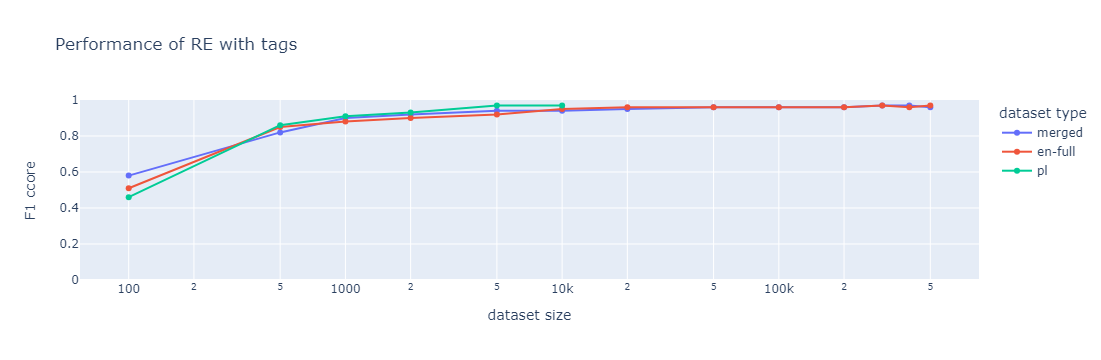

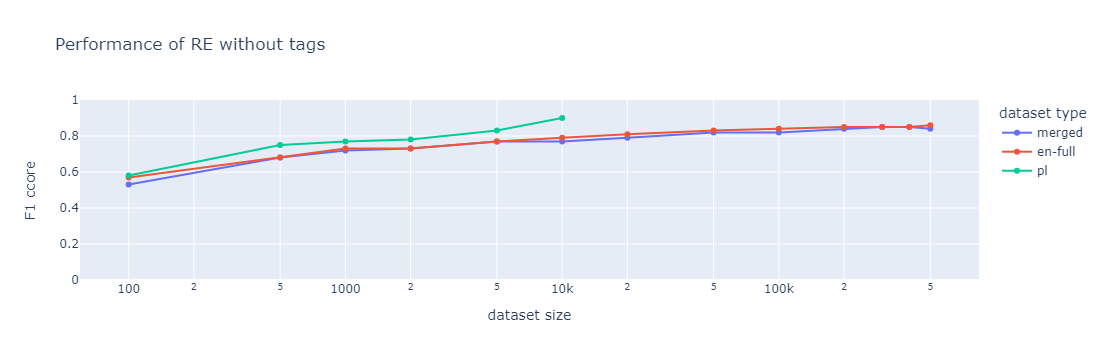

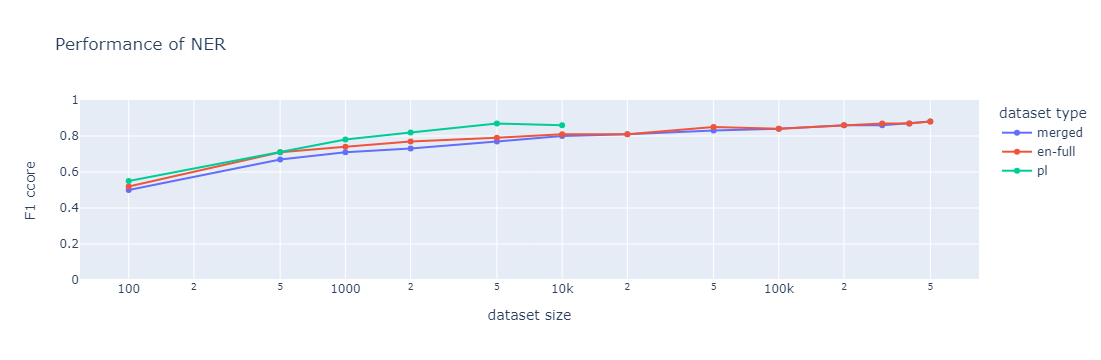

In [11]:
import plotly.graph_objects as go

# Data for the graphs (extracted from the provided table)
dataset_sizes = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 300000, 400000, 500000]

# RE with tags
re_with_tags_merged = [0.58, 0.82, 0.90, 0.92, 0.94, 0.94, 0.95, 0.96, 0.96, 0.96, 0.97, 0.97, 0.96]
re_with_tags_en_full = [0.51, 0.85, 0.88, 0.90, 0.92, 0.95, 0.96, 0.96, 0.96, 0.96, 0.97, 0.96, 0.97]
re_with_tags_pl = [0.46, 0.86, 0.91, 0.93, 0.97, 0.97] + [None] * 7

# RE no tags
re_no_tags_merged = [0.53, 0.68, 0.72, 0.73, 0.77, 0.77, 0.79, 0.82, 0.82, 0.84, 0.85, 0.85, 0.84]
re_no_tags_en_full = [0.57, 0.68, 0.73, 0.73, 0.77, 0.79, 0.81, 0.83, 0.84, 0.85, 0.85, 0.85, 0.86]
re_no_tags_pl = [0.58, 0.75, 0.77, 0.78, 0.83, 0.90] + [None] * 7

# NER
ner_merged = [0.50, 0.67, 0.71, 0.73, 0.77, 0.80, 0.81, 0.83, 0.84, 0.86, 0.86, 0.87, 0.88]
ner_en_full = [0.52, 0.71, 0.74, 0.77, 0.79, 0.81, 0.81, 0.85, 0.84, 0.86, 0.87, 0.87, 0.88]
ner_pl = [0.55, 0.71, 0.78, 0.82, 0.87, 0.86] + [None] * 7

# Creating the Plotly graphs for each model type
fig_re_with_tags = go.Figure()
fig_re_no_tags = go.Figure()
fig_ner = go.Figure()

# RE with tags Graph
for dataset, name in zip([re_with_tags_merged, re_with_tags_en_full, re_with_tags_pl],
                         ['merged', 'en-full', 'pl']):
    fig_re_with_tags.add_trace(go.Scatter(x=dataset_sizes, y=dataset, mode='lines+markers', name=name))

# RE no tags Graph
for dataset, name in zip([re_no_tags_merged, re_no_tags_en_full, re_no_tags_pl],
                         ['merged', 'en-full', 'pl']):
    fig_re_no_tags.add_trace(go.Scatter(x=dataset_sizes, y=dataset, mode='lines+markers', name=name))

# NER Graph
for dataset, name in zip([ner_merged, ner_en_full, ner_pl],
                         ['merged', 'en-full', 'pl']):
    fig_ner.add_trace(go.Scatter(x=dataset_sizes, y=dataset, mode='lines+markers', name=name))

# Update layout for each graph for better visualization
for fig, title in zip([fig_re_with_tags, fig_re_no_tags, fig_ner],
                      ['Performance of RE with tags', 'Performance of RE without tags', 'Performance of NER']):
    fig.update_layout(
        title=title,
        xaxis_title='dataset size',
        yaxis_title='F1 ccore',
        xaxis_type='log',  # Log scale for better visibility on large ranges of x
        yaxis_range=[0, 1],  # F1 scores range from 0 to 1
        legend_title='dataset type'
    )

# Show the figures
fig_re_with_tags.show()
fig_re_no_tags.show()
fig_ner.show()


## Calculating baseline F1 values for merged train

In [5]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
from collections import Counter

def random_baseline_f1(labels):
    label_counts = Counter(labels)
    total_count = sum(label_counts.values())
    label_probabilities = np.array(list(label_counts.values())) / total_count
    random_predictions = np.random.choice(a=list(label_counts.keys()), 
                                          p=label_probabilities, 
                                          size=len(labels))
    return f1_score(labels, random_predictions, average='weighted')

def most_frequent_baseline_f1(labels):
    most_common_label = Counter(labels).most_common(1)[0][0]
    constant_predictions = [most_common_label] * len(labels)
    return f1_score(labels, constant_predictions, average='weighted')

train_df = pd.read_csv('merged_train.tsv', sep='\t')
test_df = pd.read_csv('merged_test.tsv', sep='\t')
train_labels = train_df['label']
test_labels = test_df['label']
train_random_f1 = random_baseline_f1(train_labels)
train_most_frequent_f1 = most_frequent_baseline_f1(train_labels)
test_random_f1 = random_baseline_f1(test_labels)
test_most_frequent_f1 = most_frequent_baseline_f1(test_labels)
print(f"Train Random Baseline F1: {train_random_f1}")
print(f"Train Most Frequent Baseline F1: {train_most_frequent_f1}")
print(f"Test Random Baseline F1: {test_random_f1}")
print(f"Test Most Frequent Baseline F1: {test_most_frequent_f1}")

C:\Users\micha\AppData\Local\Temp\ipykernel_17700\1551063520.py:20: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('merged_train.tsv', sep='\t')


Train Random Baseline F1: 0.10777812832422327
Train Most Frequent Baseline F1: 0.05109832199099415
Test Random Baseline F1: 0.1087655089188574
Test Most Frequent Baseline F1: 0.051163256579891916


## Analyzing the labeled errors for NER

In [10]:
df=pd.read_csv('results/error_analysis_ner.csv')
correct_df=df[df['is_model_wrong']=='no']
wrong_df=df[df['is_model_wrong']=='yes']

is_model_wrong
no     500
yes    500
Name: count, dtype: int64

In [ ]:
round(correct_df['issue'].value_counts(normalize=True) * 100,2)

In [ ]:
round(wrong_df['issue'].value_counts(normalize=True) * 100,0)

## Analyzing the labeled errors for RE

In [12]:
df=pd.read_csv('results/error_analysis_re.csv')
correct_df=df[df['is_model_wrong']=='no']
wrong_df=df[df['is_model_wrong']=='yes']

In [13]:
print(len(df),len(correct_df),len(wrong_df))

1000 911 86


In [14]:
print(len(wrong_df[wrong_df["predicted_label"]=="birth-place"]))

25


In [15]:
wrong_df['predicted_label'].value_counts()

predicted_label
birth-place               25
from-country              15
is-where                   6
has-type                   5
org-has-member             4
has-occupation             4
has-parent                 4
has-genre                  4
org-has-founder            3
first-product              2
headquarters               2
has-child                  2
is-member-of               2
has-tourist-attraction     1
has-length                 1
no_relation                1
has-nationality            1
has-author                 1
won-award                  1
has-spouse                 1
has-edu                    1
Name: count, dtype: int64

In [16]:
wrong_df

,text,label,predicted_label,is_model_wrong,Unnamed: 4
20,Hajji <e1>Azwar Abubakar</e1> (born 21 June 1952 in <e2>Banda Aceh</e2>) is the current Administrative Reform Minister of Indonesia.,birth-place,from-country,yes,NaN
29,<e1>Salim Mansur</e1> is a <e2>Professor</e2> Emeritus of Political Science at the University of Western Ontario in Canada.,has-occupation,from-country,yes,NaN
35,"<e1>R. J. Q. Adams</e1> (born September 22, 1943) is an author and historian. He is <e2>professor</e2> of European and British history at Texas A & M University.",has-occupation,from-country,yes,NaN
55,"In 1995, the first <e1>Burger Fuel</e1> opened in Ponsonby, Auckland by Chris Mason. In 2007, Burger Fuel Worldwide <e2>public</e2>ly floated on the NZX.",has-type,first-product,yes,NaN
68,"<e1>Joe Atlan</e1> (born July 23, 1989 in Málaga) is a Spanish Keyboardist, Composer, YouTube Partner, and Speaker. He has performed with several <e2>music</e2>ians such as Timo Tolkki and has shared the stage with other artists like Sungha Jung.",has-occupation,is-member-of,yes,NaN
71,"<e1>Dizdarević</e1> was born into a <e2>Bosnian</e2> Muslim family in 1926. His nephew was Srđan Dizdarević, who died in 2016.",has-nationality,has-child,yes,NaN
88,"<e1>Alex Kim</e1> (born December 20, 1978) is a professional tennis player from the <e2>United States</e2>.",birth-place,is-where,yes,NaN
89,Adult <e1>emperor penguins</e1> stand up to <e2>110-130 cm</e2> (43-51 in) tall.,has-height,has-length,yes,NaN
93,"<e1>Dungu-Uye Airport</e1> is an airport serving the Kibali River town of Dungu in Orientale Province, <e2>Democratic Republic of the Congo</e2>.",is-where,has-type,yes,NaN
99,"For the <e1>Occidental Hotel</e1> in Seattle, Washington see Seattle Hotel The Occidental Hotel opened in 1861 in <e2>San Francisco, California</e2>.",is-where,has-tourist-attraction,yes,NaN
